## WNTRAC DESCRIPTIVE STATISTICS ANALYSIS

This notebook includes analysis of [WNTRAC data](https://github.com/IBM/wntrac/blob/master/data/README.md) by comparing Non-pharmaceutical Interventions implemented worldwide against those implemented by Uganda, DRC Congo, Senegal & Nigeria. Earlier version of this analysis were presented in our [paper](https://www.nature.com/articles/s41597-021-00878-y) in figures 6-12 generation code.

Find more information in our [website](https://ibm.github.io/wntrac/)

<a id="top"></a>

[Top](#top)
## Outline

[1. Install Libraries](#import)

[2. Load data](#load)

[3. Figure 6: NPIs distribution](#fig6)
    
[4. Figure 7: Territories count by NPI event types](#fig7)

[5. Figure 8: NPI event count by territories](#fig8)

[6. Figure 9: Number of NPI imposed/lifted per month over time](#fig9)

[7. Figure 10: Travel and community related NPIs analysis](#fig10)

[8. Figure 12: Adherence to NPIs ](#fig12)

<a id="import"></a>

## 1. Install and import required libraries

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
import calendar
import requests, io, zipfile
from io import BytesIO
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

mpl.rcParams['font.size'] = 14.0
mpl.rcParams["font.weight"] = "bold"
mpl.rcParams["axes.labelweight"] = "bold"

<a id="load"></a>

[Top](#top)
## 2. Load data

Fetch all the required data and load it in to pandas dataframes.
1. wntrac_events_df => WNTRAC NPIs events data. Update this with the latest data from https://github.com/IBM/wntrac/blob/master/data/README.md
2. wntrac_npi_index => WNTRAC NPI Index data. Generated from the notebook `npi_index.ipynb`
3. who_case_df => WHO COVID-19 cases data for world countries that can be downloaded from https://covid19.who.int/WHO-COVID-19-global-data.csv
4. us_cases => CDC COVID-19 cases data for US States that can be downloaded from https://data.cdc.gov/api/views/9mfq-cb36/rows.csv?accessType=DOWNLOAD
5. territories_dict => A dictinary of countries including their ISO2, ISO3 codes and population

In [2]:
# WNTRAC NPI data
latest_release_date = '2021-06-21'  # Change this date to correspond to the latest release date in the wntrac dataset in https://github.com/IBM/wntrac/blob/master/data/README.md
print('Downloading WNTRAC NPI data')
latest_data_url = 'https://github.com/IBM/wntrac/raw/master/data/ibm-wntrac-'+latest_release_date+'.zip'
r = requests.get(latest_data_url)
z = zipfile.ZipFile(BytesIO(r.content))    
wntrac_events_df = pd.read_csv(z.open('ibm-wntrac-'+latest_release_date+'-events.csv'))
print('Finished downloading WNTRAC NPI data', '\n')

# WNTRAC NPI Index data
print('Downloading WNTRAC NPI Index data')
wntrac_index_url = 'https://reward-service.eu-gb.mybluemix.net/wntracdata/csv/research/?startDate=2020-01-01' # This link is not working.
w=requests.get(wntrac_index_url).content
wntrac_npi_index = pd.read_csv(io.StringIO(w.decode('utf-8')))
print('Finished downloading WNTRAC NPI Index data', '\n')

# World countries COVID-19 outcome data
print('Downloading WHO outcome data')
csv_url = 'https://covid19.who.int/WHO-COVID-19-global-data.csv'
r = requests.get(csv_url)
if r.status_code != 200:
    print('Download error, code = {}'.format(r.status_code))
world_cedp_outcome_df = pd.read_csv(io.StringIO(r.content.decode('utf-8')), na_filter=False)
world_cedp_outcome_df.columns = [i.strip().lower() for i in world_cedp_outcome_df.columns]
world_cedp_outcome_df['country_code'] = world_cedp_outcome_df.apply(lambda row: row.country_code if row.country != 'Other' else 'Other',
                                                axis=1)
who_case_df = world_cedp_outcome_df
print('Finished downloading WHO outcome data', '\n')

# US States COVID-19 outcome data
print('Downloading CDC outcome data')
us_states_dict = [{"admin1_iso2":"US-AL","admin1_iso_name":"Alabama","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-AL","Population":4864680},{"admin1_iso2":"US-AK","admin1_iso_name":"Alaska","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-AK","Population":738516},{"admin1_iso2":"US-AZ","admin1_iso_name":"Arizona","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-AZ","Population":6946685},{"admin1_iso2":"US-AR","admin1_iso_name":"Arkansas","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-AR","Population":2990671},{"admin1_iso2":"US-CA","admin1_iso_name":"California","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-CA","Population":39148760},{"admin1_iso2":"US-CO","admin1_iso_name":"Colorado","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-CO","Population":5531141},{"admin1_iso2":"US-CT","admin1_iso_name":"Connecticut","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-CT","Population":3581504},{"admin1_iso2":"US-DE","admin1_iso_name":"Delaware","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-DE","Population":949495},{"admin1_iso2":"US-DC","admin1_iso_name":"District of Columbia","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-DC","Population":684498},{"admin1_iso2":"US-FL","admin1_iso_name":"Florida","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-FL","Population":20598139},{"admin1_iso2":"US-GA","admin1_iso_name":"Georgia","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-GA","Population":10297484},{"admin1_iso2":"US-HI","admin1_iso_name":"Hawaii","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-HI","Population":1422029},{"admin1_iso2":"US-ID","admin1_iso_name":"Idaho","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-ID","Population":1687809},{"admin1_iso2":"US-IL","admin1_iso_name":"Illinois","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-IL","Population":12821497},{"admin1_iso2":"US-IN","admin1_iso_name":"Indiana","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-IN","Population":6637426},{"admin1_iso2":"US-IA","admin1_iso_name":"Iowa","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-IA","Population":3132499},{"admin1_iso2":"US-KS","admin1_iso_name":"Kansas","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-KS","Population":2908776},{"admin1_iso2":"US-KY","admin1_iso_name":"Kentucky","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-KY","Population":4440204},{"admin1_iso2":"US-LA","admin1_iso_name":"Louisiana","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-LA","Population":4663616},{"admin1_iso2":"US-ME","admin1_iso_name":"Maine","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-ME","Population":1332813},{"admin1_iso2":"US-MD","admin1_iso_name":"Maryland","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-MD","Population":6003435},{"admin1_iso2":"US-MA","admin1_iso_name":"Massachusetts","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-MA","Population":6830193},{"admin1_iso2":"US-MI","admin1_iso_name":"Michigan","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-MI","Population":9957488},{"admin1_iso2":"US-MN","admin1_iso_name":"Minnesota","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-MN","Population":5527358},{"admin1_iso2":"US-MS","admin1_iso_name":"Mississippi","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-MS","Population":2988762},{"admin1_iso2":"US-MO","admin1_iso_name":"Missouri","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-MO","Population":6090062},{"admin1_iso2":"US-MT","admin1_iso_name":"Montana","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-MT","Population":1041732},{"admin1_iso2":"US-NE","admin1_iso_name":"Nebraska","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-NE","Population":1904760},{"admin1_iso2":"US-NV","admin1_iso_name":"Nevada","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-NV","Population":2922849},{"admin1_iso2":"US-NH","admin1_iso_name":"New Hampshire","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-NH","Population":1343622},{"admin1_iso2":"US-NJ","admin1_iso_name":"New Jersey","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-NJ","Population":8881845},{"admin1_iso2":"US-NM","admin1_iso_name":"New Mexico","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-NM","Population":2092434},{"admin1_iso2":"US-NY","admin1_iso_name":"New York","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-NY","Population":19618453},{"admin1_iso2":"US-NC","admin1_iso_name":"North Carolina","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-NC","Population":10155624},{"admin1_iso2":"US-ND","admin1_iso_name":"North Dakota","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-ND","Population":752201},{"admin1_iso2":"US-OH","admin1_iso_name":"Ohio","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-OH","Population":11641879},{"admin1_iso2":"US-OK","admin1_iso_name":"Oklahoma","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-OK","Population":3918137},{"admin1_iso2":"US-OR","admin1_iso_name":"Oregon","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-OR","Population":4081943},{"admin1_iso2":"US-PA","admin1_iso_name":"Pennsylvania","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-PA","Population":12791181},{"admin1_iso2":"US-RI","admin1_iso_name":"Rhode Island","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-RI","Population":1056611},{"admin1_iso2":"US-SC","admin1_iso_name":"South Carolina","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-SC","Population":4955925},{"admin1_iso2":"US-SD","admin1_iso_name":"South Dakota","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-SD","Population":864289},{"admin1_iso2":"US-TN","admin1_iso_name":"Tennessee","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-TN","Population":6651089},{"admin1_iso2":"US-TX","admin1_iso_name":"Texas","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-TX","Population":27885195},{"admin1_iso2":"US-UT","admin1_iso_name":"Utah","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-UT","Population":3045350},{"admin1_iso2":"US-VT","admin1_iso_name":"Vermont","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-VT","Population":624977},{"admin1_iso2":"US-VA","admin1_iso_name":"Virginia","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-VA","Population":8413774},{"admin1_iso2":"US-WA","admin1_iso_name":"Washington","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-WA","Population":7294336},{"admin1_iso2":"US-WV","admin1_iso_name":"West Virginia","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-WV","Population":1829054},{"admin1_iso2":"US-WI","admin1_iso_name":"Wisconsin","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-WI","Population":5778394},{"admin1_iso2":"US-WY","admin1_iso_name":"Wyoming","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-WY","Population":581836},{"admin1_iso2":"US-PR","admin1_iso_name":"Puerto Rico","admin0_iso_name":"United States","admin0_iso2":"US","admin0_iso3":"USA","admin1_iso3":"USA-PR","Population":3386941}]
cdc_data_url = 'https://data.cdc.gov/api/views/9mfq-cb36/rows.csv?accessType=DOWNLOAD'
s=requests.get(cdc_data_url).content
us_states_cedp_outcome_df = pd.read_csv(io.StringIO(s.decode('utf-8')))
us_states_cedp_outcome_df.rename(columns={'submission_date': 'dt', 'state': 'province_id', 'tot_cases': 'confirmed_cases',
                                 'tot_death': 'deaths', 'new_case': 'confirmed_cases_delta',
                                 'new_death': 'deaths_delta', 'created_at': 'collected'}, inplace=True)
us_states_cedp_outcome_df['province_id'] = 'US-' + us_states_cedp_outcome_df['province_id']
outliers = ['US-AS', 'US-VI', 'US-PW', 'US-MP', 'US-GU']
us_states_cedp_outcome_df = us_states_cedp_outcome_df[(us_states_cedp_outcome_df['province_id'].map(len) == 5) & ~(us_states_cedp_outcome_df['province_id'].isin(outliers))]
us_states_cedp_outcome_df['country_id'] = 'US' 
us_states_dict = {td['admin1_iso2']: td for td in us_states_dict}
us_states_cedp_outcome_df['province_name'] = [us_states_dict[prov_id]['admin1_iso_name'] for prov_id in us_states_cedp_outcome_df['province_id']]
us_states_cedp_outcome_df = us_states_cedp_outcome_df[['province_id', 'confirmed_cases', 'deaths', 'confirmed_cases_delta', 'deaths_delta', 'dt', 'collected', 'country_id', 'province_name']]
us_cases = us_states_cedp_outcome_df
print('Finished downloading CDC outcome data', '\n')
 
territories_dict = [{"admin0_iso_name":"Afghanistan","admin0_iso2":"AF","admin0_iso3":"AFG","Population":38928341},{"admin0_iso_name":"Albania","admin0_iso2":"AL","admin0_iso3":"ALB","Population":2877800},{"admin0_iso_name":"Algeria","admin0_iso2":"DZ","admin0_iso3":"DZA","Population":43851043},{"admin0_iso_name":"Andorra","admin0_iso2":"AD","admin0_iso3":"AND","Population":77265},{"admin0_iso_name":"Angola","admin0_iso2":"AO","admin0_iso3":"AGO","Population":32866268},{"admin0_iso_name":"Antigua and Barbuda","admin0_iso2":"AG","admin0_iso3":"ATG","Population":97928},{"admin0_iso_name":"Argentina","admin0_iso2":"AR","admin0_iso3":"ARG","Population":45195777},{"admin0_iso_name":"Armenia","admin0_iso2":"AM","admin0_iso3":"ARM","Population":2963234},{"admin0_iso_name":"Austria","admin0_iso2":"AT","admin0_iso3":"AUT","Population":9006400},{"admin0_iso_name":"Azerbaijan","admin0_iso2":"AZ","admin0_iso3":"AZE","Population":10139175},{"admin0_iso_name":"Bahamas","admin0_iso2":"BS","admin0_iso3":"BHS","Population":393248},{"admin0_iso_name":"Bahrain","admin0_iso2":"BH","admin0_iso3":"BHR","Population":1701583},{"admin0_iso_name":"Bangladesh","admin0_iso2":"BD","admin0_iso3":"BGD","Population":164689383},{"admin0_iso_name":"Barbados","admin0_iso2":"BB","admin0_iso3":"BRB","Population":287371},{"admin0_iso_name":"Belarus","admin0_iso2":"BY","admin0_iso3":"BLR","Population":9449321},{"admin0_iso_name":"Belgium","admin0_iso2":"BE","admin0_iso3":"BEL","Population":11589616},{"admin0_iso_name":"Belize","admin0_iso2":"BZ","admin0_iso3":"BLZ","Population":397621},{"admin0_iso_name":"Benin","admin0_iso2":"BJ","admin0_iso3":"BEN","Population":12123198},{"admin0_iso_name":"Bhutan","admin0_iso2":"BT","admin0_iso3":"BTN","Population":771612},{"admin0_iso_name":"Bolivia","admin0_iso2":"BO","admin0_iso3":"BOL","Population":11673029},{"admin0_iso_name":"Bosnia and Herzegovina","admin0_iso2":"BA","admin0_iso3":"BIH","Population":3280815},{"admin0_iso_name":"Botswana","admin0_iso2":"BW","admin0_iso3":"BWA","Population":2351625},{"admin0_iso_name":"Brazil","admin0_iso2":"BR","admin0_iso3":"BRA","Population":212559409},{"admin0_iso_name":"Brunei","admin0_iso2":"BN","admin0_iso3":"BRN","Population":437483},{"admin0_iso_name":"Bulgaria","admin0_iso2":"BG","admin0_iso3":"BGR","Population":6948445},{"admin0_iso_name":"Burkina Faso","admin0_iso2":"BF","admin0_iso3":"BFA","Population":20903278},{"admin0_iso_name":"Burma","admin0_iso2":"MM","admin0_iso3":"MMR","Population":54409794},{"admin0_iso_name":"Burundi","admin0_iso2":"BI","admin0_iso3":"BDI","Population":11890781},{"admin0_iso_name":"Cabo Verde","admin0_iso2":"CV","admin0_iso3":"CPV","Population":555988},{"admin0_iso_name":"Cambodia","admin0_iso2":"KH","admin0_iso3":"KHM","Population":16718971},{"admin0_iso_name":"Cameroon","admin0_iso2":"CM","admin0_iso3":"CMR","Population":26545864},{"admin0_iso_name":"Central African Republic","admin0_iso2":"CF","admin0_iso3":"CAF","Population":4829764},{"admin0_iso_name":"Chad","admin0_iso2":"TD","admin0_iso3":"TCD","Population":16425859},{"admin0_iso_name":"Chile","admin0_iso2":"CL","admin0_iso3":"CHL","Population":19116209},{"admin0_iso_name":"Colombia","admin0_iso2":"CO","admin0_iso3":"COL","Population":50882884},{"admin0_iso_name":"Congo (Brazzaville)","admin0_iso2":"CG","admin0_iso3":"COG","Population":5518092},{"admin0_iso_name":"Congo (Kinshasa)","admin0_iso2":"CD","admin0_iso3":"COD","Population":89561404},{"admin0_iso_name":"Comoros","admin0_iso2":"KM","admin0_iso3":"COM","Population":869595},{"admin0_iso_name":"Costa Rica","admin0_iso2":"CR","admin0_iso3":"CRI","Population":5094114},{"admin0_iso_name":"Cote d'Ivoire","admin0_iso2":"CI","admin0_iso3":"CIV","Population":26378275},{"admin0_iso_name":"Croatia","admin0_iso2":"HR","admin0_iso3":"HRV","Population":4105268},{"admin0_iso_name":"Cuba","admin0_iso2":"CU","admin0_iso3":"CUB","Population":11326616},{"admin0_iso_name":"Cyprus","admin0_iso2":"CY","admin0_iso3":"CYP","Population":1207361},{"admin0_iso_name":"Czechia","admin0_iso2":"CZ","admin0_iso3":"CZE","Population":10708982},{"admin0_iso_name":"Denmark","admin0_iso2":"DK","admin0_iso3":"DNK","Population":5792203},{"admin0_iso_name":"Faroe Islands, Denmark","admin0_iso2":"FO","admin0_iso3":"FRO","Population":48865},{"admin0_iso_name":"Greenland, Denmark","admin0_iso2":"GL","admin0_iso3":"GRL","Population":56772},{"admin0_iso_name":"Diamond Princess","admin0_iso2":"","admin0_iso3":"","Population":""},{"admin0_iso_name":"Djibouti","admin0_iso2":"DJ","admin0_iso3":"DJI","Population":988002},{"admin0_iso_name":"Dominica","admin0_iso2":"DM","admin0_iso3":"DMA","Population":71991},{"admin0_iso_name":"Dominican Republic","admin0_iso2":"DO","admin0_iso3":"DOM","Population":10847904},{"admin0_iso_name":"Ecuador","admin0_iso2":"EC","admin0_iso3":"ECU","Population":17643060},{"admin0_iso_name":"Egypt","admin0_iso2":"EG","admin0_iso3":"EGY","Population":102334403},{"admin0_iso_name":"El Salvador","admin0_iso2":"SV","admin0_iso3":"SLV","Population":6486201},{"admin0_iso_name":"Equatorial Guinea","admin0_iso2":"GQ","admin0_iso3":"GNQ","Population":1402985},{"admin0_iso_name":"Eritrea","admin0_iso2":"ER","admin0_iso3":"ERI","Population":3546427},{"admin0_iso_name":"Estonia","admin0_iso2":"EE","admin0_iso3":"EST","Population":1326539},{"admin0_iso_name":"Eswatini","admin0_iso2":"SZ","admin0_iso3":"SWZ","Population":1160164},{"admin0_iso_name":"Ethiopia","admin0_iso2":"ET","admin0_iso3":"ETH","Population":114963583},{"admin0_iso_name":"Fiji","admin0_iso2":"FJ","admin0_iso3":"FJI","Population":896444},{"admin0_iso_name":"Finland","admin0_iso2":"FI","admin0_iso3":"FIN","Population":5540718},{"admin0_iso_name":"France","admin0_iso2":"FR","admin0_iso3":"FRA","Population":65273512},{"admin0_iso_name":"French Guiana, France","admin0_iso2":"GF","admin0_iso3":"GUF","Population":298682},{"admin0_iso_name":"French Polynesia, France","admin0_iso2":"PF","admin0_iso3":"PYF","Population":280904},{"admin0_iso_name":"Guadeloupe, France","admin0_iso2":"GP","admin0_iso3":"GLP","Population":400127},{"admin0_iso_name":"Martinique, France","admin0_iso2":"MQ","admin0_iso3":"MTQ","Population":375265},{"admin0_iso_name":"Mayotte, France","admin0_iso2":"YT","admin0_iso3":"MYT","Population":272813},{"admin0_iso_name":"New Caledonia, France","admin0_iso2":"NC","admin0_iso3":"NCL","Population":285491},{"admin0_iso_name":"Reunion, France","admin0_iso2":"RE","admin0_iso3":"REU","Population":895308},{"admin0_iso_name":"Saint Barthelemy, France","admin0_iso2":"BL","admin0_iso3":"BLM","Population":9885},{"admin0_iso_name":"Saint Pierre and Miquelon, France","admin0_iso2":"PM","admin0_iso3":"SPM","Population":5795},{"admin0_iso_name":"St Martin, France","admin0_iso2":"MF","admin0_iso3":"MAF","Population":38659},{"admin0_iso_name":"Wallis and Futuna, France","admin0_iso2":"WF","admin0_iso3":"WLF","Population":15289},{"admin0_iso_name":"Gabon","admin0_iso2":"GA","admin0_iso3":"GAB","Population":2225728},{"admin0_iso_name":"Gambia","admin0_iso2":"GM","admin0_iso3":"GMB","Population":2416664},{"admin0_iso_name":"Georgia","admin0_iso2":"GE","admin0_iso3":"GEO","Population":3989175},{"admin0_iso_name":"Germany","admin0_iso2":"DE","admin0_iso3":"DEU","Population":83783945},{"admin0_iso_name":"Ghana","admin0_iso2":"GH","admin0_iso3":"GHA","Population":31072945},{"admin0_iso_name":"Greece","admin0_iso2":"GR","admin0_iso3":"GRC","Population":10423056},{"admin0_iso_name":"Grenada","admin0_iso2":"GD","admin0_iso3":"GRD","Population":112519},{"admin0_iso_name":"Guatemala","admin0_iso2":"GT","admin0_iso3":"GTM","Population":17915567},{"admin0_iso_name":"Guinea","admin0_iso2":"GN","admin0_iso3":"GIN","Population":13132792},{"admin0_iso_name":"Guinea-Bissau","admin0_iso2":"GW","admin0_iso3":"GNB","Population":1967998},{"admin0_iso_name":"Guyana","admin0_iso2":"GY","admin0_iso3":"GUY","Population":786559},{"admin0_iso_name":"Haiti","admin0_iso2":"HT","admin0_iso3":"HTI","Population":11402533},{"admin0_iso_name":"Holy See","admin0_iso2":"VA","admin0_iso3":"VAT","Population":809},{"admin0_iso_name":"Honduras","admin0_iso2":"HN","admin0_iso3":"HND","Population":9904608},{"admin0_iso_name":"Hungary","admin0_iso2":"HU","admin0_iso3":"HUN","Population":9660350},{"admin0_iso_name":"Iceland","admin0_iso2":"IS","admin0_iso3":"ISL","Population":341250},{"admin0_iso_name":"India","admin0_iso2":"IN","admin0_iso3":"IND","Population":1380004385},{"admin0_iso_name":"Indonesia","admin0_iso2":"ID","admin0_iso3":"IDN","Population":273523621},{"admin0_iso_name":"Iran","admin0_iso2":"IR","admin0_iso3":"IRN","Population":83992953},{"admin0_iso_name":"Iraq","admin0_iso2":"IQ","admin0_iso3":"IRQ","Population":40222503},{"admin0_iso_name":"Ireland","admin0_iso2":"IE","admin0_iso3":"IRL","Population":4937796},{"admin0_iso_name":"Israel","admin0_iso2":"IL","admin0_iso3":"ISR","Population":8655541},{"admin0_iso_name":"Italy","admin0_iso2":"IT","admin0_iso3":"ITA","Population":60461828},{"admin0_iso_name":"Jamaica","admin0_iso2":"JM","admin0_iso3":"JAM","Population":2961161},{"admin0_iso_name":"Japan","admin0_iso2":"JP","admin0_iso3":"JPN","Population":126476458},{"admin0_iso_name":"Jordan","admin0_iso2":"JO","admin0_iso3":"JOR","Population":10203140},{"admin0_iso_name":"Kazakhstan","admin0_iso2":"KZ","admin0_iso3":"KAZ","Population":18776707},{"admin0_iso_name":"Kenya","admin0_iso2":"KE","admin0_iso3":"KEN","Population":53771300},{"admin0_iso_name":"Korea, South","admin0_iso2":"KR","admin0_iso3":"KOR","Population":51269183},{"admin0_iso_name":"Kosovo","admin0_iso2":"XK","admin0_iso3":"XKS","Population":1810366},{"admin0_iso_name":"Kuwait","admin0_iso2":"KW","admin0_iso3":"KWT","Population":4270563},{"admin0_iso_name":"Kyrgyzstan","admin0_iso2":"KG","admin0_iso3":"KGZ","Population":6524191},{"admin0_iso_name":"Laos","admin0_iso2":"LA","admin0_iso3":"LAO","Population":7275556},{"admin0_iso_name":"Latvia","admin0_iso2":"LV","admin0_iso3":"LVA","Population":1886202},{"admin0_iso_name":"Lebanon","admin0_iso2":"LB","admin0_iso3":"LBN","Population":6825442},{"admin0_iso_name":"Lesotho","admin0_iso2":"LS","admin0_iso3":"LSO","Population":2142252},{"admin0_iso_name":"Liberia","admin0_iso2":"LR","admin0_iso3":"LBR","Population":5057677},{"admin0_iso_name":"Libya","admin0_iso2":"LY","admin0_iso3":"LBY","Population":6871287},{"admin0_iso_name":"Liechtenstein","admin0_iso2":"LI","admin0_iso3":"LIE","Population":38137},{"admin0_iso_name":"Lithuania","admin0_iso2":"LT","admin0_iso3":"LTU","Population":2722291},{"admin0_iso_name":"Luxembourg","admin0_iso2":"LU","admin0_iso3":"LUX","Population":625976},{"admin0_iso_name":"Madagascar","admin0_iso2":"MG","admin0_iso3":"MDG","Population":27691019},{"admin0_iso_name":"Malawi","admin0_iso2":"MW","admin0_iso3":"MWI","Population":19129955},{"admin0_iso_name":"Malaysia","admin0_iso2":"MY","admin0_iso3":"MYS","Population":32365998},{"admin0_iso_name":"Maldives","admin0_iso2":"MV","admin0_iso3":"MDV","Population":540542},{"admin0_iso_name":"Mali","admin0_iso2":"ML","admin0_iso3":"MLI","Population":20250834},{"admin0_iso_name":"Malta","admin0_iso2":"MT","admin0_iso3":"MLT","Population":441539},{"admin0_iso_name":"Marshall Islands","admin0_iso2":"MH","admin0_iso3":"MHL","Population":58413},{"admin0_iso_name":"Mauritania","admin0_iso2":"MR","admin0_iso3":"MRT","Population":4649660},{"admin0_iso_name":"Mauritius","admin0_iso2":"MU","admin0_iso3":"MUS","Population":1271767},{"admin0_iso_name":"Mexico","admin0_iso2":"MX","admin0_iso3":"MEX","Population":127792286},{"admin0_iso_name":"Moldova","admin0_iso2":"MD","admin0_iso3":"MDA","Population":4033963},{"admin0_iso_name":"Monaco","admin0_iso2":"MC","admin0_iso3":"MCO","Population":39244},{"admin0_iso_name":"Mongolia","admin0_iso2":"MN","admin0_iso3":"MNG","Population":3278292},{"admin0_iso_name":"Montenegro","admin0_iso2":"ME","admin0_iso3":"MNE","Population":628062},{"admin0_iso_name":"Morocco","admin0_iso2":"MA","admin0_iso3":"MAR","Population":36910558},{"admin0_iso_name":"Mozambique","admin0_iso2":"MZ","admin0_iso3":"MOZ","Population":31255435},{"admin0_iso_name":"MS Zaandam","admin0_iso2":"","admin0_iso3":"","Population":""},{"admin0_iso_name":"Namibia","admin0_iso2":"","admin0_iso3":"NAM","Population":2540916},{"admin0_iso_name":"Nepal","admin0_iso2":"NP","admin0_iso3":"NPL","Population":29136808},{"admin0_iso_name":"Netherlands","admin0_iso2":"NL","admin0_iso3":"NLD","Population":17134873},{"admin0_iso_name":"Aruba, Netherlands","admin0_iso2":"AW","admin0_iso3":"ABW","Population":106766},{"admin0_iso_name":"Curacao, Netherlands","admin0_iso2":"CW","admin0_iso3":"CUW","Population":164100},{"admin0_iso_name":"Sint Maarten, Netherlands","admin0_iso2":"SX","admin0_iso3":"SXM","Population":42882},{"admin0_iso_name":"Bonaire, Sint Eustatius and Saba, Netherlands","admin0_iso2":"BQ","admin0_iso3":"BES","Population":26221},{"admin0_iso_name":"New Zealand","admin0_iso2":"NZ","admin0_iso3":"NZL","Population":4822233},{"admin0_iso_name":"Nicaragua","admin0_iso2":"NI","admin0_iso3":"NIC","Population":6624554},{"admin0_iso_name":"Niger","admin0_iso2":"NE","admin0_iso3":"NER","Population":24206636},{"admin0_iso_name":"Nigeria","admin0_iso2":"NG","admin0_iso3":"NGA","Population":206139587},{"admin0_iso_name":"North Macedonia","admin0_iso2":"MK","admin0_iso3":"MKD","Population":2083380},{"admin0_iso_name":"Norway","admin0_iso2":"NO","admin0_iso3":"NOR","Population":5421242},{"admin0_iso_name":"Oman","admin0_iso2":"OM","admin0_iso3":"OMN","Population":5106622},{"admin0_iso_name":"Pakistan","admin0_iso2":"PK","admin0_iso3":"PAK","Population":220892331},{"admin0_iso_name":"Panama","admin0_iso2":"PA","admin0_iso3":"PAN","Population":4314768},{"admin0_iso_name":"Papua New Guinea","admin0_iso2":"PG","admin0_iso3":"PNG","Population":8947027},{"admin0_iso_name":"Paraguay","admin0_iso2":"PY","admin0_iso3":"PRY","Population":7132530},{"admin0_iso_name":"Peru","admin0_iso2":"PE","admin0_iso3":"PER","Population":32971846},{"admin0_iso_name":"Philippines","admin0_iso2":"PH","admin0_iso3":"PHL","Population":109581085},{"admin0_iso_name":"Poland","admin0_iso2":"PL","admin0_iso3":"POL","Population":37846605},{"admin0_iso_name":"Portugal","admin0_iso2":"PT","admin0_iso3":"PRT","Population":10196707},{"admin0_iso_name":"Qatar","admin0_iso2":"QA","admin0_iso3":"QAT","Population":2881060},{"admin0_iso_name":"Romania","admin0_iso2":"RO","admin0_iso3":"ROU","Population":19237682},{"admin0_iso_name":"Russia","admin0_iso2":"RU","admin0_iso3":"RUS","Population":145934460},{"admin0_iso_name":"Rwanda","admin0_iso2":"RW","admin0_iso3":"RWA","Population":12952209},{"admin0_iso_name":"Saint Kitts and Nevis","admin0_iso2":"KN","admin0_iso3":"KNA","Population":53192},{"admin0_iso_name":"Saint Lucia","admin0_iso2":"LC","admin0_iso3":"LCA","Population":183629},{"admin0_iso_name":"Saint Vincent and the Grenadines","admin0_iso2":"VC","admin0_iso3":"VCT","Population":110947},{"admin0_iso_name":"San Marino","admin0_iso2":"SM","admin0_iso3":"SMR","Population":33938},{"admin0_iso_name":"Sao Tome and Principe","admin0_iso2":"ST","admin0_iso3":"STP","Population":219161},{"admin0_iso_name":"Saudi Arabia","admin0_iso2":"SA","admin0_iso3":"SAU","Population":34813867},{"admin0_iso_name":"Senegal","admin0_iso2":"SN","admin0_iso3":"SEN","Population":16743930},{"admin0_iso_name":"Serbia","admin0_iso2":"RS","admin0_iso3":"SRB","Population":8737370},{"admin0_iso_name":"Seychelles","admin0_iso2":"SC","admin0_iso3":"SYC","Population":98340},{"admin0_iso_name":"Sierra Leone","admin0_iso2":"SL","admin0_iso3":"SLE","Population":7976985},{"admin0_iso_name":"Singapore","admin0_iso2":"SG","admin0_iso3":"SGP","Population":5850343},{"admin0_iso_name":"Slovakia","admin0_iso2":"SK","admin0_iso3":"SVK","Population":5459643},{"admin0_iso_name":"Slovenia","admin0_iso2":"SI","admin0_iso3":"SVN","Population":2078932},{"admin0_iso_name":"Solomon Islands","admin0_iso2":"SB","admin0_iso3":"SLB","Population":652858},{"admin0_iso_name":"Somalia","admin0_iso2":"SO","admin0_iso3":"SOM","Population":15893219},{"admin0_iso_name":"South Africa","admin0_iso2":"ZA","admin0_iso3":"ZAF","Population":59308690},{"admin0_iso_name":"South Sudan","admin0_iso2":"SS","admin0_iso3":"SSD","Population":11193729},{"admin0_iso_name":"Spain","admin0_iso2":"ES","admin0_iso3":"ESP","Population":46754783},{"admin0_iso_name":"Sri Lanka","admin0_iso2":"LK","admin0_iso3":"LKA","Population":21413250},{"admin0_iso_name":"Sudan","admin0_iso2":"SD","admin0_iso3":"SDN","Population":43849269},{"admin0_iso_name":"Suriname","admin0_iso2":"SR","admin0_iso3":"SUR","Population":586634},{"admin0_iso_name":"Sweden","admin0_iso2":"SE","admin0_iso3":"SWE","Population":10099270},{"admin0_iso_name":"Switzerland","admin0_iso2":"CH","admin0_iso3":"CHE","Population":8654618},{"admin0_iso_name":"Syria","admin0_iso2":"SY","admin0_iso3":"SYR","Population":17500657},{"admin0_iso_name":"Taiwan*","admin0_iso2":"TW","admin0_iso3":"TWN","Population":23816775},{"admin0_iso_name":"Tajikistan","admin0_iso2":"TJ","admin0_iso3":"TJK","Population":9537642},{"admin0_iso_name":"Tanzania","admin0_iso2":"TZ","admin0_iso3":"TZA","Population":59734213},{"admin0_iso_name":"Thailand","admin0_iso2":"TH","admin0_iso3":"THA","Population":69799978},{"admin0_iso_name":"Timor-Leste","admin0_iso2":"TL","admin0_iso3":"TLS","Population":1318442},{"admin0_iso_name":"Togo","admin0_iso2":"TG","admin0_iso3":"TGO","Population":8278737},{"admin0_iso_name":"Trinidad and Tobago","admin0_iso2":"TT","admin0_iso3":"TTO","Population":1399491},{"admin0_iso_name":"Tunisia","admin0_iso2":"TN","admin0_iso3":"TUN","Population":11818618},{"admin0_iso_name":"Turkey","admin0_iso2":"TR","admin0_iso3":"TUR","Population":84339067},{"admin0_iso_name":"Uganda","admin0_iso2":"UG","admin0_iso3":"UGA","Population":45741000},{"admin0_iso_name":"Ukraine","admin0_iso2":"UA","admin0_iso3":"UKR","Population":43733759},{"admin0_iso_name":"United Arab Emirates","admin0_iso2":"AE","admin0_iso3":"ARE","Population":9890400},{"admin0_iso_name":"United Kingdom","admin0_iso2":"GB","admin0_iso3":"GBR","Population":67886004},{"admin0_iso_name":"Bermuda, United Kingdom","admin0_iso2":"BM","admin0_iso3":"BMU","Population":62273},{"admin0_iso_name":"British Virgin Islands, United Kingdom","admin0_iso2":"VG","admin0_iso3":"VGB","Population":30237},{"admin0_iso_name":"Cayman Islands, United Kingdom","admin0_iso2":"KY","admin0_iso3":"CYM","Population":65720},{"admin0_iso_name":"Falkland Islands (Malvinas), United Kingdom","admin0_iso2":"FK","admin0_iso3":"FLK","Population":3483},{"admin0_iso_name":"Gibraltar, United Kingdom","admin0_iso2":"GI","admin0_iso3":"GIB","Population":33691},{"admin0_iso_name":"Isle of Man, United Kingdom","admin0_iso2":"IM","admin0_iso3":"IMN","Population":85032},{"admin0_iso_name":"Montserrat, United Kingdom","admin0_iso2":"MS","admin0_iso3":"MSR","Population":4999},{"admin0_iso_name":"Turks and Caicos Islands, United Kingdom","admin0_iso2":"TC","admin0_iso3":"TCA","Population":38718},{"admin0_iso_name":"Anguilla, United Kingdom","admin0_iso2":"AI","admin0_iso3":"AIA","Population":15002},{"admin0_iso_name":"Uruguay","admin0_iso2":"UY","admin0_iso3":"URY","Population":3473727},{"admin0_iso_name":"Uzbekistan","admin0_iso2":"UZ","admin0_iso3":"UZB","Population":33469199},{"admin0_iso_name":"Vanuatu","admin0_iso2":"VU","admin0_iso3":"VUT","Population":292680},{"admin0_iso_name":"Venezuela","admin0_iso2":"VE","admin0_iso3":"VEN","Population":28435943},{"admin0_iso_name":"Vietnam","admin0_iso2":"VN","admin0_iso3":"VNM","Population":97338583},{"admin0_iso_name":"West Bank and Gaza","admin0_iso2":"PS","admin0_iso3":"PSE","Population":5101416},{"admin0_iso_name":"Western Sahara","admin0_iso2":"EH","admin0_iso3":"ESH","Population":597330},{"admin0_iso_name":"Yemen","admin0_iso2":"YE","admin0_iso3":"YEM","Population":29825968},{"admin0_iso_name":"Zambia","admin0_iso2":"ZM","admin0_iso3":"ZMB","Population":18383956},{"admin0_iso_name":"Zimbabwe","admin0_iso2":"ZW","admin0_iso3":"ZWE","Population":14862927},{"admin0_iso_name":"Australia","admin0_iso2":"AU","admin0_iso3":"AUS","Population":25459700},{"admin0_iso_name":"Canada","admin0_iso2":"CA","admin0_iso3":"CAN","Population":37855702},{"admin0_iso_name":"China","admin0_iso2":"CN","admin0_iso3":"CHN","Population":1404676330},{"admin0_iso_name":"Hong Kong, China","admin0_iso2":"HK","admin0_iso3":"HKG","Population":7496988},{"admin0_iso_name":"Macau, China","admin0_iso2":"MO","admin0_iso3":"MAC","Population":649342},{"admin0_iso_name":"US","admin0_iso2":"US","admin0_iso3":"USA","Population":329466283},{"admin0_iso_name":"American Samoa, US","admin0_iso2":"AS","admin0_iso3":"ASM","Population":55641},{"admin0_iso_name":"Guam, US","admin0_iso2":"GU","admin0_iso3":"GUM","Population":164229},{"admin0_iso_name":"Northern Mariana Islands, US","admin0_iso2":"MP","admin0_iso3":"MNP","Population":55144},{"admin0_iso_name":"Virgin Islands, US","admin0_iso2":"VI","admin0_iso3":"VIR","Population":107268},{"admin0_iso_name":"Puerto Rico, US","admin0_iso2":"PR","admin0_iso3":"PRI","Population":2933408}]

africa = ['UGA', 'SEN', 'COD', 'NGA', 'CMR'] 

colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9']
colorDict = {'entertainment/cultural sector closure': '#e6194B', 'confinement': '#3cb44b', 'school closure': '#ffe119', 'freedom of movement (nationality dependent)': '#4363d8', 'international flight restrictions': '#f58231', 'introduction of travel quarantine policies': '#911eb4', 'state of emergency (legal impact)': '#42d4f4', 'mass gatherings': '#f032e6', 'work restrictions': '#bfef45', 'economic impact': '#fabed4', 'mask wearing': '#469990', 'public transportation': '#dcbeff', 'public services closure': '#9A6324', 'domestic flight restriction': '#fffac8', 'contact tracing': '#800000', 'changes in prison-related policies': '#aaffc3', 'other': '#808000'}
if not os.path.exists('plots'):
    os.makedirs('plots')        

Finished downloading WNTRAC NPI data 

Finished downloading WNTRAC NPI Index data 

Finished downloading WHO outcome data 

Finished downloading CDC outcome data 



In [3]:
w

b"404 Not Found: Requested route ('reward-service.eu-gb.mybluemix.net') does not exist.\n"

<a id="fig6"></a>

[Top](#top)
## 3. Figure 6: NPIs distribution

In [4]:
def generate_figure_six(event_approved, title):
    def my_autopct(pct):
        return ('%1.1f%%' % pct) if pct > 0.6 else ''

    my_labels = []
    for val, cnt in event_approved['type'].value_counts().iteritems():
        my_labels.append(f'{val} ({cnt})')
    orderOfTypes = []
    for val, cnt in event_approved['type'].value_counts().iteritems():
        orderOfTypes.append(val)
    pie = event_approved.type.value_counts().plot(kind='pie', figsize=(10,10), autopct=my_autopct, labels =['']*len(orderOfTypes), colors=[colorDict[orderOfType] for orderOfType in orderOfTypes])

    pie.legend(labels = my_labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=12)
    pie.set_title(title, fontdict= { 'fontsize': 12, 'verticalalignment': 'bottom'}) 
    pie.figure.savefig('./plots/'+title+'stats-npi-distribution_.jpeg', dpi=1000)
    return orderOfTypes

### Figure 6a: Global NPIs distribution

Figure shows the distribution of the NPIs imposed worldwide as recorded in the dataset.

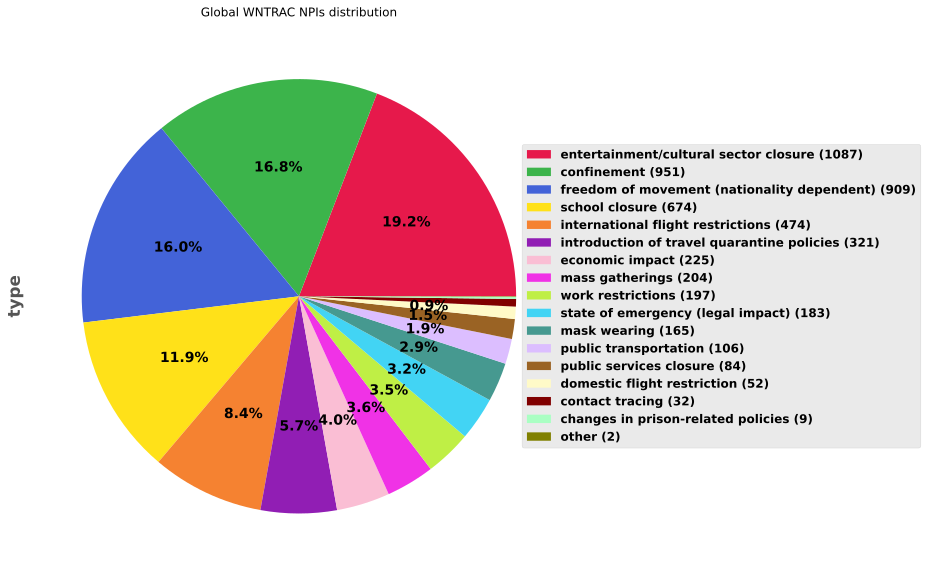

In [5]:
event_approved = wntrac_events_df.loc[wntrac_events_df['state/province'].isnull()]
orderOfTypes = generate_figure_six(event_approved, "Global WNTRAC NPIs distribution")

### Figure 6b: Uganda, Senegal, DRC, Nigeria & Cameroon  NPIs distribution

Figure shows the distribution of the NPIs imposed in Uganda, Senegal, DRC, Nigeria & Cameroon as recorded in the dataset.

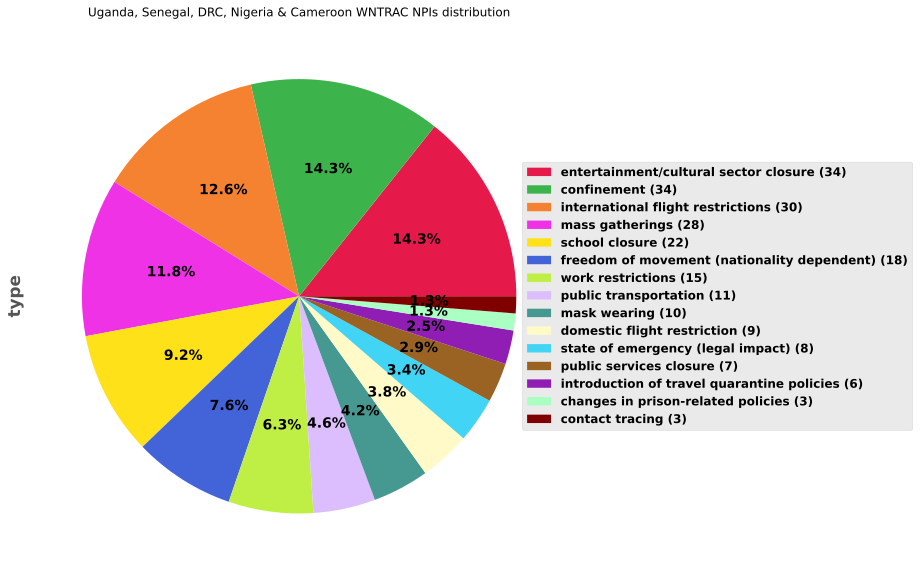

In [6]:
africa_event_approved = event_approved[event_approved['country'].isin(africa)].copy()
afr_orderOfTypes = generate_figure_six(africa_event_approved, "Uganda, Senegal, DRC, Nigeria & Cameroon WNTRAC NPIs distribution")

<a id="fig7"></a>

[Top](#top)
## 4. Figure 7: Territories count by NPI event types

Figure summarizes the total number of regions that implemented NPIs of each type

### Figure 7a: Territories count by NPIs global

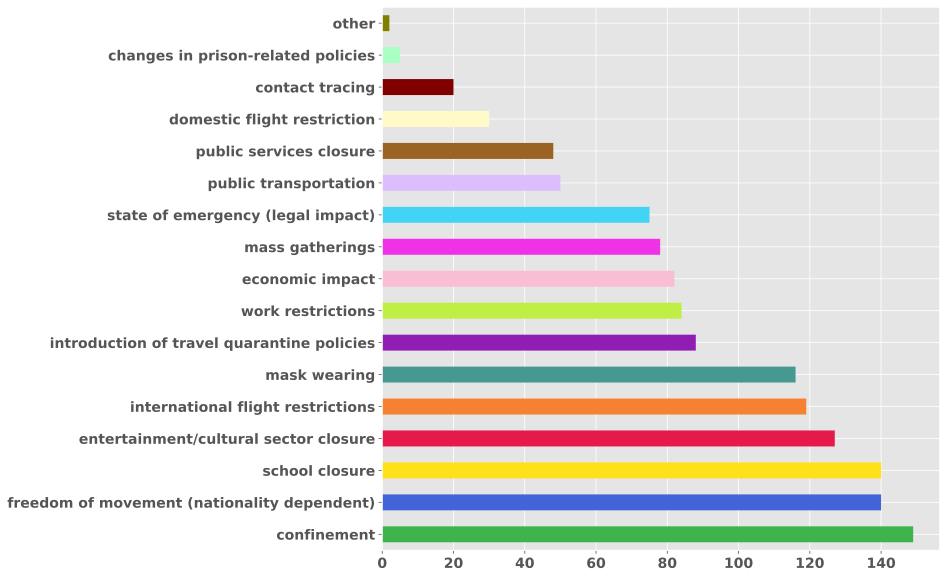

In [7]:
# rest_freq = event_approved[~event_approved['country'].str.startswith('USA-')]
rest_freq = event_approved[~event_approved['country'].isin(africa)].copy()
rest_freqData = rest_freq[['country', 'type']]
rest_freqData = rest_freqData.drop_duplicates()
rest_freqData = rest_freqData.type.value_counts()
rest_freq_colors = []
for val, cnt in rest_freqData.iteritems():
    rest_freq_colors.append(colorDict[val])

rest_freq_plot = rest_freqData.plot(kind='barh', figsize=(10,10), color = rest_freq_colors)

rest_freq_plot.figure.savefig('./plots/stats-region-count-by-npi.jpeg', dpi=1200)

### Figure 7b: Territories count by NPI for Uganda, Senegal, DRC, Nigeria & Cameroon

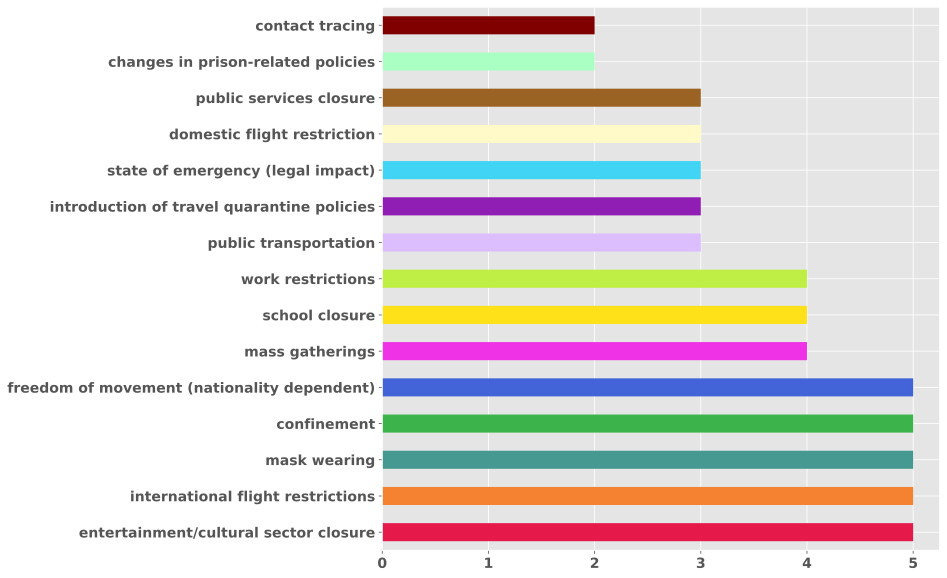

In [8]:
afr_freq = africa_event_approved.copy()
afr_freqData = afr_freq[['country', 'type']]
afr_freqData.head()
afr_freqData = afr_freqData.drop_duplicates()
afr_freqData = afr_freqData.type.value_counts()
afr_freq_colors = []
for val, cnt in afr_freqData.iteritems():
    afr_freq_colors.append(colorDict[val])

afr_freq_plot = afr_freqData.plot(kind='barh', figsize=(10,10), color = afr_freq_colors)

afr_freq_plot.figure.savefig('./plots/maksph_stats-region-count-by-npi.jpeg', dpi=1200)

<a id="fig8"></a>

[Top](#top)
## 5. Figure 8: NPI event count by territories

Figure shows the breakdown of the NPIs within each region, for the top 20 regions that implemented the highest number of NPIs.

### Figure 8a: Global count by territories

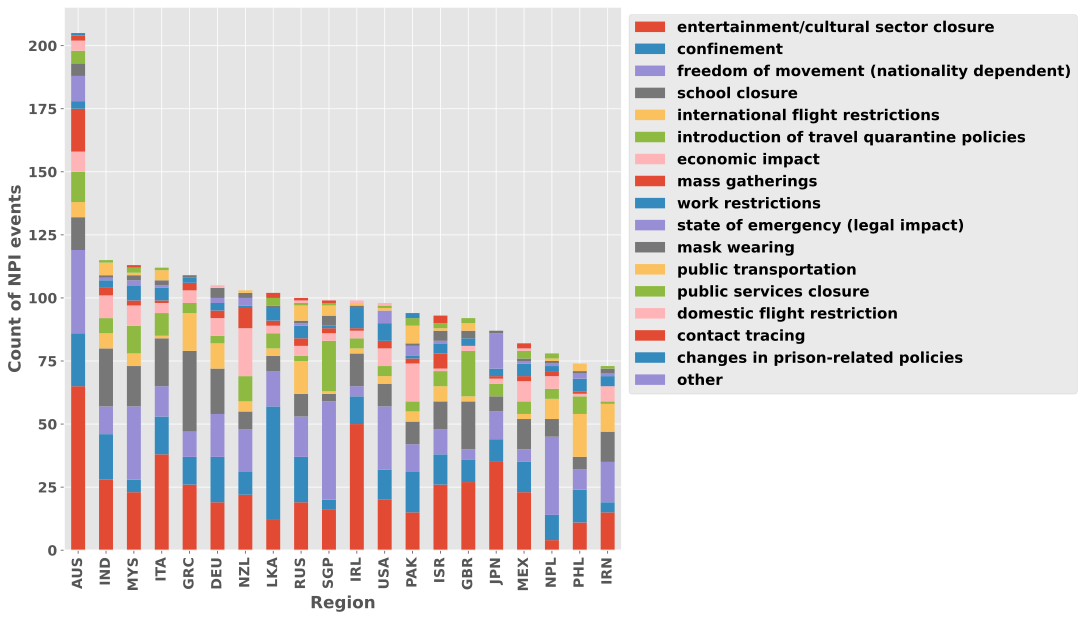

In [9]:
rest = event_approved[~event_approved['country'].isin(africa)].copy()
rest_highest = rest.country.value_counts().head(20).index.tolist()
rest_data = event_approved[event_approved['country'].isin(rest_highest)]

rest_barData = rest_data[['country', 'type']]
rest_barData
rest_barData['count'] = 1

rest_pivot_table = pd.pivot_table(rest_barData, index='country', columns='type', values='count', aggfunc=np.sum, fill_value = 0)
rest_pivot_table = rest_pivot_table.reindex(orderOfTypes, axis = 1)
rest_pivot_table

rest_plot = rest_pivot_table.loc[rest_highest].plot.bar(stacked=True, figsize=(10,10))
rest_plot.legend(bbox_to_anchor=(1.0, 1.0), fontsize=15)
rest_plot.set_ylabel('Count of NPI events')
rest_plot.set_xlabel('Region')
rest_plot.figure.savefig('./plots/stats-npi-count-by-region.jpeg', dpi=1200)

### Figure 8b: Uganda, Senegal, DRC, Nigeria & Cameroun count by territory

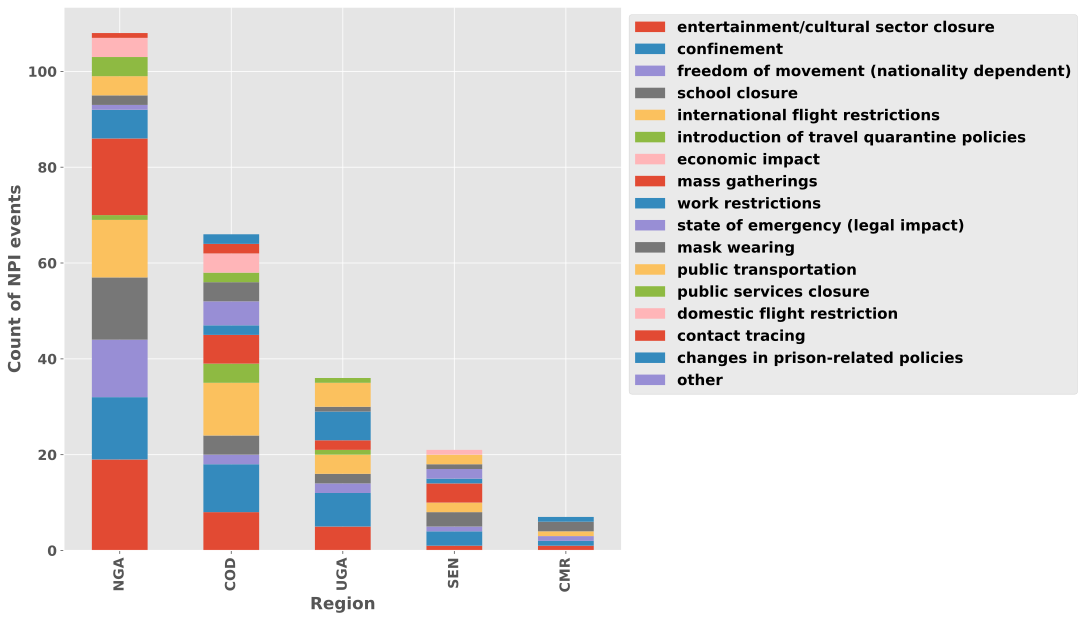

In [10]:
afr = africa_event_approved.copy()
afr_highest = afr['country'].value_counts().head(20).index.tolist()
afr_data = event_approved[event_approved['country'].isin(afr_highest)]

afr_barData = afr_data[['country', 'type']]
afr_barData.loc[:, 'count'] = 1
afr_barData
afr_pivot_table = pd.pivot_table(afr_barData, index='country', columns='type', values='count', aggfunc=np.sum, fill_value = 0)
afr_pivot_table = afr_pivot_table.reindex(orderOfTypes, axis = 1)

afr_plot = afr_pivot_table.loc[afr_highest].plot.bar(stacked=True, figsize=(10,10))
afr_plot.legend(bbox_to_anchor=(1.0, 1.0), fontsize=15)
afr_plot.set_ylabel('Count of NPI events')
afr_plot.set_xlabel('Region')

afr_plot.figure.savefig('./plots/maksph_stats-npi-count-by-region.jpeg', dpi=1200)

<a id="fig9"></a>

[Top](#top)
## 6. Figure 9: Number of NPI imposed/lifted per month over time 

Figure illustrates the total number of NPIs imposed and lifted in all geographies per month.


#### Get NPI count per month

In [11]:
def get_npi_count_per_month(this_df, restriction):
    this_df = this_df[this_df['restriction']==restriction]
    # add month-year column
    this_df['month'] = this_df['date'].dt.strftime('%b-%Y')
    this_df = this_df[['month', 'restriction']]

    # Group by month and find restriction count per month
    grouped_df = this_df.groupby(['month'])['restriction'].count().reset_index(name='count')
    grouped_df['date'] = pd.to_datetime(grouped_df['month'], format='%b-%Y', errors='coerce')
    grouped_df = grouped_df.sort_values(['date']) 
    return grouped_df
    

#### NPI count plots

In [12]:
def plot_npi_count(imp_df, lif_df, max_count, category):
    sns.set(rc={'figure.figsize':(28,8)})
    sns.set_style("white")
    sns.set_color_codes('bright') 

    #Modified from https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig, axes = plt.subplots(1,2, sharex=False)

    #create first plot
    ax =axes[0]
    ax.bar(imp_df['month'], imp_df['count'],color = '#469990')
    ax.set_xlabel("", fontsize=22, fontweight='bold')
    ax.set_ylabel("Count", fontsize=22, fontweight='bold')
    ax.set_ylim([0,max_count])
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='x', which='major', labelsize=22, rotation=90)
    ax.tick_params(axis='both', which='minor', labelsize=22)
    ax.set_title('(a) Imposed', fontsize=28, fontweight='bold',y=-0.35)

    #create second plot
    ax2 =axes[1]
    ax2.bar(lif_df['month'], lif_df['count'],color = '#469990')
    ax2.set_xlabel("", fontsize=22, fontweight='bold')
    ax2.set_ylabel("", fontsize=22, fontweight='bold')
    ax2.set_ylim([0,max_count])
    ax2.tick_params(axis='both', which='major', labelsize=22)
    ax2.tick_params(axis='x', which='major', labelsize=22, rotation=90)
    ax2.tick_params(axis='both', which='minor', labelsize=22)
    ax2.set_title('(b) Lifted', fontsize=28, fontweight='bold',y=-0.35)

    plt.subplots_adjust(wspace=0.15, hspace=0.5)
    fig.tight_layout()
    plt.savefig('plots/'+category+'-9-usage-notes-number-of-imposed-lifted.jpeg', dpi=300, bbox_inches='tight')
    plt.show()

### Figure 9a: Global number of NPI imposed/lifted per month over time

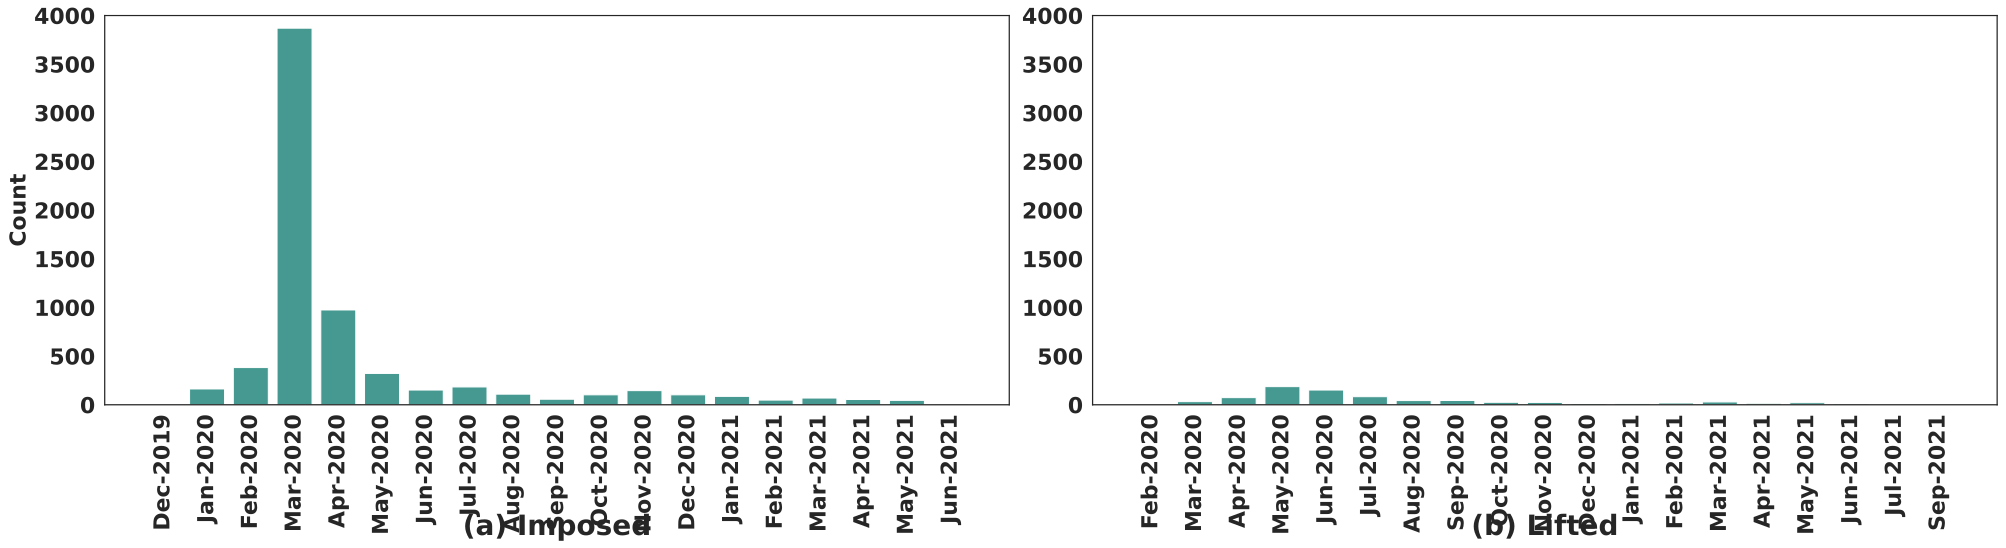

In [13]:
df = wntrac_events_df.copy()
df['date'] = pd.to_datetime(df['date'])
# Discard NPI events with irrelevant dates
df= df[df['date']<=datetime.strptime('2021-12-01', '%Y-%m-%d')]
df= df[df['date']>datetime.strptime('2019-12-01', '%Y-%m-%d')]

plot_npi_count(get_npi_count_per_month(df, 1), get_npi_count_per_month(df, 0), 4000, 'global')

### Figure 9b: Uganda, Senegal, DRC,  Nigeria & Cameroon number of NPI imposed/lifted per month over time

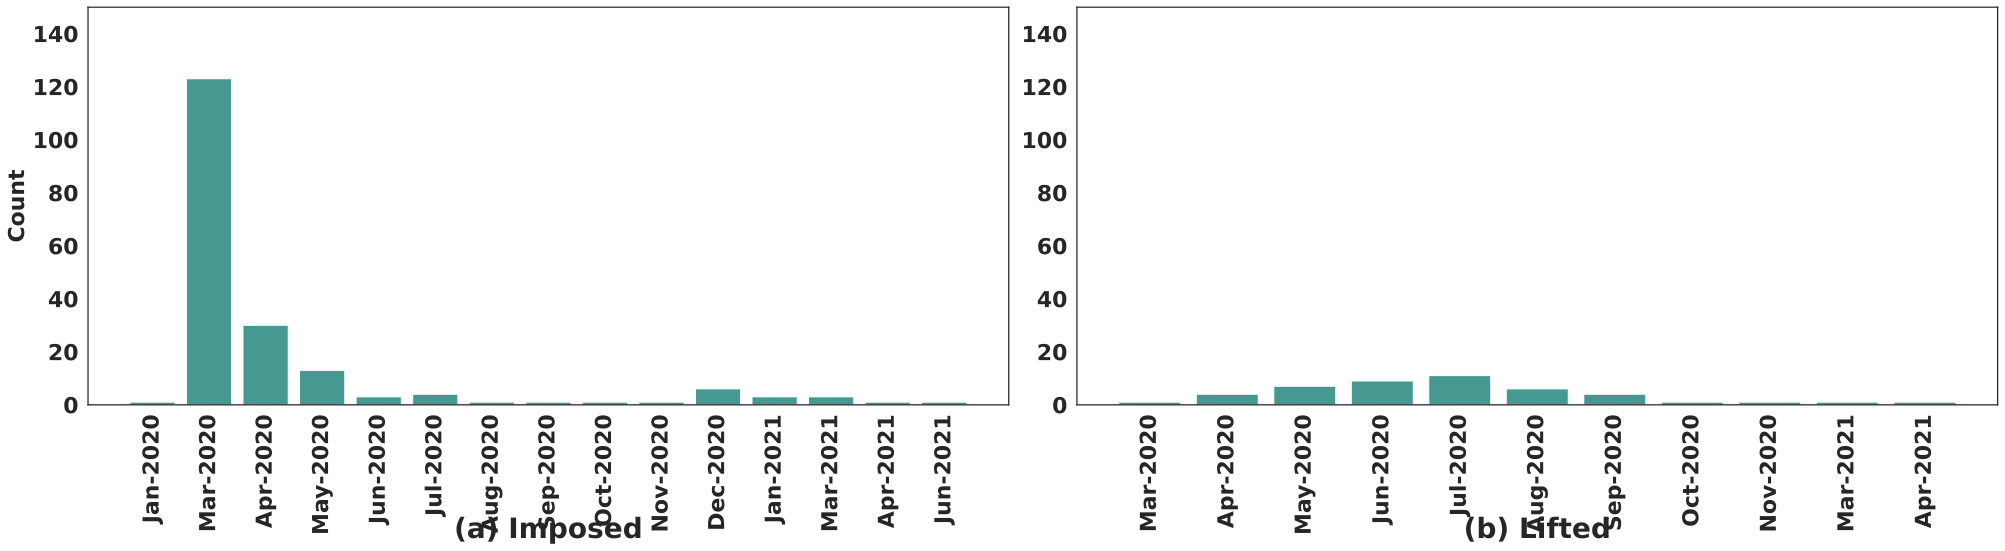

In [14]:
afr_df = df[df['country'].isin(africa)].copy()
plot_npi_count(get_npi_count_per_month(afr_df, 1), get_npi_count_per_month(afr_df, 0), 150, 'maksph')

<a id="fig10"></a>

[Top](#top)
## 7. Figure 10: Travel and community related NPIs analysis 

Figure shows the number of days between the implementation of travel-related NPI vs community-related NPI and two outcomes of interest: (i) the recording of at least 50 cases (shown with blue points), and (ii) the first reported death due to COVID-19 (shown with red points). In the figure, days less than zero denote the number of days prior to the outcome of interest. The number of days greater than 0 denote the amount of time that passed after the specific outcome.

#### Get Covid-19 NPIs Longitudinal Format
Generates csv files combining NPI data with WHO/ECDC Covid-19 outcomes

##### World NPIs

In [15]:
#load NPI datasets
npi_df = wntrac_events_df.copy()
replacements = {'2019-03-18':'2020-03-18', '2019-05-06':'2020-05-06'}
npi_df = npi_df.replace({'date' : replacements})
npi_df['date'] = pd.to_datetime(npi_df['date'])
npi_df = npi_df.replace({'country' : {'KOS':'KVX'}})

#2. Selected a subset of 13 NPIs for subsequent analysis.
exclusion_list = ['economic impact','contact tracing','changes in prison-related policies', 'domestic of movement','other']
npi_df_filtered = npi_df[~npi_df['type'].isin(exclusion_list)]

#3. Get only country-level data
npi_df_filtered = npi_df_filtered[(npi_df_filtered['state/province'].isna())|(npi_df_filtered['state/province']=='None')]


#4. Discard NPI events with future dates
date_string = '2021-12-01'
last_date = datetime.strptime(date_string, '%Y-%m-%d')
npi_df_filtered= npi_df_filtered[npi_df_filtered['date']<=last_date]

#5. select distinct country-NPI-date tuples
npi_df_filtered = npi_df_filtered.drop(['state/province','epoch','even_id','value'],axis=1).drop_duplicates().sort_values(['country', 'type', 'date'])
mask = npi_df_filtered['restriction']!= npi_df_filtered.groupby(['type','country'])['restriction'].shift(1)
npi_df_filtered = npi_df_filtered[mask]
npi_df_filtered['end_date'] = npi_df_filtered.groupby(['type','country','type'])['date'].shift(-1)
npi_df_filtered['end_date'] =npi_df_filtered['end_date'].fillna(last_date)

##### World Cases - WHO

In [16]:
countries = sorted(list(np.unique(npi_df_filtered['country'])))

iso_country_codes_json = territories_dict.copy()
iso_country_codes = pd.DataFrame(data=iso_country_codes_json)
iso_country_codes.rename(columns={'admin0_iso2': 'Alpha-2 code', 'admin0_iso3':'Alpha-3 code'}, inplace=True)
iso_country_codes = dict(zip(iso_country_codes['Alpha-2 code'], iso_country_codes['Alpha-3 code']))

who_case_df.columns = [i.strip().lower() for i in who_case_df.columns]
who_case_df['country_code'] = who_case_df.apply(lambda row: row.country_code if row.country != 'Other' else 'Other',
                                                axis=1)
#who_case_df =who_case_df.drop(['new_deaths','cumulative_deaths'], axis=1)
who_case_df['country_code'] = [iso_country_codes[i] if ((i != 'Other') & (i in iso_country_codes)) else i for i in who_case_df['country_code']]
who_case_df = who_case_df[who_case_df['country_code'].isin(countries)]
who_case_df['date_reported'] = pd.to_datetime(who_case_df['date_reported'])
who_case_df = who_case_df[who_case_df['date_reported']<last_date]

who_case_df['new_cases'] = who_case_df['new_cases'].astype(int)
who_case_df['cumulative_cases'] = who_case_df['cumulative_cases'].astype(int)
day_zero_one_case = {}
day_zero_fifty_cases = {}
day_zero_one_hundred_cases = {}
for country in countries:
    if country in set(who_case_df['country_code']):
        country_who_case_df = who_case_df[who_case_df['country_code']==country].copy()
        day_zero_one_case[country] = country_who_case_df['date_reported'][country_who_case_df['cumulative_cases']>=1].min()
        day_zero_fifty_cases[country] = country_who_case_df['date_reported'][country_who_case_df['cumulative_cases']>=50].min()
        day_zero_one_hundred_cases[country] = country_who_case_df['date_reported'][country_who_case_df['cumulative_cases']>=100].min()

who_case_df['days_since_first_case'] = who_case_df.apply(lambda x: (x.date_reported - day_zero_one_case[x.country_code]).days, axis=1)
who_case_df['days_since_fifty_cases'] = who_case_df.apply(lambda x: (x.date_reported - day_zero_fifty_cases[x.country_code]).days, axis=1)
who_case_df['days_since_one_hundred_cases'] = who_case_df.apply(lambda x: (x.date_reported - day_zero_one_hundred_cases[x.country_code]).days, axis=1)

who_case_df['new_cases_ewm7'] = who_case_df.groupby('country_code')['new_cases'].transform(lambda x: x.ewm(span=7).mean())
who_case_df['new_cases_sma7'] = who_case_df.groupby('country_code')['new_cases'].transform(lambda x: x.rolling(window=7).mean())
who_case_df['cumulative_cases_ewm7'] = who_case_df.groupby('country_code')['cumulative_cases'].transform(lambda x: x.ewm(span=7).mean())
who_case_df['cumulative_cases_sma7'] = who_case_df.groupby('country_code')['cumulative_cases'].transform(lambda x: x.rolling(window=7).mean())


who_case_df['new_deaths_ewm7'] = who_case_df.groupby('country_code')['new_deaths'].transform(lambda x: x.ewm(span=7).mean())
who_case_df['new_dealths_sma7'] = who_case_df.groupby('country_code')['new_deaths'].transform(lambda x: x.rolling(window=7).mean())
who_case_df['cumulative_deaths_ewm7'] = who_case_df.groupby('country_code')['cumulative_deaths'].transform(lambda x: x.ewm(span=7).mean())
who_case_df['cumulative_deaths_sma7'] = who_case_df.groupby('country_code')['cumulative_deaths'].transform(lambda x: x.rolling(window=7).mean())

# who_case_df.to_csv('who_case_df.csv', index=False)
who_case_df[who_case_df['country_code']=='AND'].tail(10)

,date_reported,country_code,country,who_region,new_cases,cumulative_cases,new_deaths,cumulative_deaths,days_since_first_case,days_since_fifty_cases,days_since_one_hundred_cases,new_cases_ewm7,new_cases_sma7,cumulative_cases_ewm7,cumulative_cases_sma7,new_deaths_ewm7,new_dealths_sma7,cumulative_deaths_ewm7,cumulative_deaths_sma7
4300,2021-11-21,AND,Andorra,EURO,0,16086,0,130,628,611.0,609.0,32.773101,38.142857,15987.680697,15976.285714,1.945427e-12,0.000000,130.000000,130.000000
4301,2021-11-22,AND,Andorra,EURO,0,16086,0,130,629,612.0,610.0,24.579826,38.142857,16012.260523,16014.428571,1.459070e-12,0.000000,130.000000,130.000000
4302,2021-11-23,AND,Andorra,EURO,213,16299,0,130,630,613.0,611.0,71.684869,56.000000,16083.945392,16070.428571,1.094303e-12,0.000000,130.000000,130.000000
4303,2021-11-24,AND,Andorra,EURO,43,16342,0,130,631,614.0,612.0,64.513652,59.000000,16148.459044,16129.428571,8.207269e-13,0.000000,130.000000,130.000000
4304,2021-11-25,AND,Andorra,EURO,84,16426,1,131,632,615.0,613.0,69.385239,64.857143,16217.844283,16194.285714,2.500000e-01,0.142857,130.250000,130.142857
4305,2021-11-26,AND,Andorra,EURO,140,16566,0,131,633,616.0,614.0,87.038929,75.857143,16304.883212,16270.142857,1.875000e-01,0.142857,130.437500,130.285714
4306,2021-11-27,AND,Andorra,EURO,146,16712,0,131,634,617.0,615.0,101.779197,89.428571,16406.662409,16359.571429,1.406250e-01,0.142857,130.578125,130.428571
4307,2021-11-28,AND,Andorra,EURO,0,16712,0,131,635,618.0,616.0,76.334398,89.428571,16482.996807,16449.000000,1.054688e-01,0.142857,130.683594,130.571429
4308,2021-11-29,AND,Andorra,EURO,0,16712,0,131,636,619.0,617.0,57.250798,89.428571,16540.247605,16538.428571,7.910156e-02,0.142857,130.762695,130.714286
4309,2021-11-30,AND,Andorra,EURO,403,17115,0,131,637,620.0,618.0,143.688099,116.571429,16683.935704,16655.000000,5.932617e-02,0.142857,130.822021,130.857143


##### US States NPIs

In [17]:
#2. Selected a subset of 13 NPIs for subsequent analysis.
exclusion_list = ['economic impact','contact tracing','changes in prison-related policies', 'domestic of movement','other']
npi_df_filtered = npi_df[~npi_df['type'].isin(exclusion_list)]

#3. Get only US state data
npi_df_filtered = npi_df_filtered[npi_df_filtered['country']=='USA'].copy()
npi_df_filtered = npi_df_filtered[~((npi_df_filtered['state/province'].isna())|(npi_df_filtered['state/province']=='None'))]

#4. Discard NPI events with future dates
last_date = datetime.strptime(date_string, '%Y-%m-%d')
npi_df_filtered= npi_df_filtered[npi_df_filtered['date']<=last_date]

#5. select distinct US State-NPI-date tuples
npi_df_filtered = npi_df_filtered.drop(['epoch','even_id','value'],axis=1).drop_duplicates().sort_values(['state/province', 'type', 'date'])
mask = npi_df_filtered['restriction']!= npi_df_filtered.groupby(['type','state/province'])['restriction'].shift(1)
npi_df_filtered = npi_df_filtered[mask]
npi_df_filtered['end_date'] = npi_df_filtered.groupby(['type','state/province','type'])['date'].shift(-1)
npi_df_filtered['end_date'] =npi_df_filtered['end_date'].fillna(last_date)

##### US States Cases - CDC

In [18]:
states = sorted(list(np.unique(npi_df_filtered['state/province'])))
us_cases['dt'] =pd.to_datetime(us_cases['dt'])
us_cases = us_cases.rename(columns={'dt': 'date_reported','confirmed_cases_delta':'new_cases', 'deaths_delta':'new_deaths'})
us_cases['province_id'] =[i.replace('US-','USA-') for i in us_cases['province_id']]
us_cases['date_reported'] = pd.to_datetime(us_cases['date_reported'],format="%d/%m/%Y")
us_cases=us_cases[us_cases['date_reported']<last_date]

day_zero_one_case = {}
day_zero_fifty_cases = {}
day_zero_one_hundred_cases = {}
for state in states:
    if state in set(us_cases['province_id']):
        state_cases = us_cases[us_cases['province_id']==state].copy()
        day_zero_one_case[state] = state_cases['date_reported'][state_cases['confirmed_cases']>=1].min()
        day_zero_fifty_cases[state] = state_cases['date_reported'][state_cases['confirmed_cases']>=50].min()
        day_zero_one_hundred_cases[state] = state_cases['date_reported'][state_cases['confirmed_cases']>=100].min()

us_cases['days_since_first_case'] = us_cases.apply(lambda x: (x.date_reported - day_zero_one_case[x.province_id]).days, axis=1)
us_cases['days_since_fifty_cases'] = us_cases.apply(lambda x: (x.date_reported - day_zero_fifty_cases[x.province_id]).days, axis=1)
us_cases['days_since_one_hundred_cases'] = us_cases.apply(lambda x: (x.date_reported - day_zero_one_hundred_cases[x.province_id]).days, axis=1)
us_cases['country_code'] = us_cases['province_name'].str.replace(' ', '')
us_cases['new_cases_ewm7'] = us_cases.groupby('country_code')['new_cases'].transform(lambda x: x.ewm(span=7).mean())
us_cases

,province_id,confirmed_cases,deaths,new_cases,new_deaths,date_reported,collected,country_id,province_name,days_since_first_case,days_since_fifty_cases,days_since_one_hundred_cases,country_code,new_cases_ewm7
0,USA-KS,297229,4851,0,0,2021-03-11,03/12/2021 03:20:13 PM,US,Kansas,368,355,350,Kansas,0.000000
2,USA-UT,359641,1785,1060,11,2021-02-12,02/13/2021 02:50:08 PM,US,Utah,341,330,329,Utah,1060.000000
4,USA-ND,118491,1562,536,1,2021-09-01,09/02/2021 01:49:05 PM,US,North Dakota,538,524,520,NorthDakota,536.000000
5,USA-AR,56199,674,547,11,2020-08-22,08/23/2020 02:15:28 PM,US,Arkansas,164,156,155,Arkansas,547.000000
7,USA-MD,127290,4092,471,3,2020-10-04,10/06/2020 12:00:00 AM,US,Maryland,213,201,199,Maryland,471.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52974,USA-DC,25339,720,301,4,2020-12-15,12/16/2020 02:28:57 PM,US,District of Columbia,283,271,268,DistrictofColumbia,132.273812
52975,USA-SD,122660,1967,128,5,2021-04-30,05/01/2021 01:43:22 PM,US,South Dakota,416,399,396,SouthDakota,96.050440
52977,USA-AZ,1245127,21942,3249,2,2021-11-22,11/23/2021 02:18:53 PM,US,Arizona,666,612,611,Arizona,2157.195727
52978,USA-TN,1215767,14952,2124,18,2021-09-27,09/26/2021 12:00:00 AM,US,Tennessee,563,556,555,Tennessee,3353.384293


##### Functions to find time difference from first NPI to first death 

In [19]:
# The purpose of these functions is to match first NPI with first death or 50 confirmed cases, 
# and find out the time deference between them
# 
# The output of the function:
def add_NPI_data(df_NPIs, df_covid_data, cm_date_col='date', cm_country_col='country', npi_col='event_name',
                 end_date_str=None, start_date_str=None, remove_NPIs=[], inf_date_col='date',
                 inf_country_col='country_code', start_from_50_cases=True):
    
    
    df_NPIs[cm_date_col] = pd.to_datetime(df_NPIs[cm_date_col])  # 'date'
    df_covid_data[inf_date_col] = pd.to_datetime(df_covid_data[inf_date_col])  # date_reported
    if end_date_str is not None:
        end_date = datetime.strptime(end_date_str, '%m/%d/%Y')
        df_NPIs = df_NPIs[(df_NPIs[cm_date_col] < end_date)]
        df_covid_data = df_covid_data[(df_covid_data[inf_date_col] < end_date)]
    if start_date_str is not None:
        start_date = datetime.strptime(start_date_str, '%m/%d/%Y')
        df_NPIs = df_NPIs[(df_NPIs[cm_date_col] > start_date)]
        df_covid_data = df_covid_data[(df_covid_data[inf_date_col] > start_date)]
    if len(remove_NPIs) > 0:
        df_NPIs = df_NPIs[~df_NPIs[npi_col].isin(remove_NPIs)]
    first_CM_to_first_infection = {}
    states = df_covid_data[inf_country_col].unique() 
    for state in states:
        # select curr state data only
        df_npis_ = df_NPIs[df_NPIs[cm_country_col] == state]
        df_inf_ = df_covid_data[df_covid_data[inf_country_col] == state]
        df_npis_.sort_values(by=cm_date_col, inplace=True, ascending=True)
        df_inf_.sort_values(by=inf_date_col, inplace=True, ascending=True)
        country_name = df_inf_[inf_country_col].values[0]
        if start_from_50_cases:
            df_inf_ = df_inf_[df_inf_['days_since_fifty_cases'] > 0]
        # filter state if negative
        if (df_inf_.new_cases_ewm7 < -1).any():
            neg_indx = df_inf_[df_inf_.new_cases_ewm7 < -1].index[0]
            df_inf_ = df_inf_.drop(df_inf_.index[np.where(np.array(df_inf_.index) == neg_indx)[0][0]:])
        if len(df_npis_) < 1:
            print('--- add_NPI_data: less than 1 NPI for: ', state)
            print(len(df_npis_))
            print(df_NPIs.columns.values)
            continue
        first_CM_to_first_infection[country_name] = []
        cc_npi = get_days_from_NPI(df_npis_, df_inf_, col1='new_cases', col2=npi_col)  # confirmed_cases
        dth_npi = get_days_from_NPI(df_npis_, df_inf_, col1='new_deaths', col2=npi_col)  # deaths
        if any(isinstance(el, list) for el in cc_npi):
            first_CM_to_first_infection[country_name] = first_CM_to_first_infection[country_name] + cc_npi[0]
            first_CM_to_first_infection[country_name] = first_CM_to_first_infection[country_name] + dth_npi[0]
        else:
            first_CM_to_first_infection[country_name] = first_CM_to_first_infection[country_name] + cc_npi
            first_CM_to_first_infection[country_name] = first_CM_to_first_infection[country_name] + dth_npi
        first_CM_to_first_infection[state].append(df_inf_['country'].values[0])

    return pd.DataFrame.from_dict(first_CM_to_first_infection, orient='index',
                                  columns=['first_NPI_to_first_cc', 'first_NPI_cc', 'first_NPIcc_date',
                                           'first_cc_date'] + \
                                          ['first_NPI_to_first_dth', 'first_NPI_dth', 'first_NPIdth_date',
                                           'first_dth_date', 'Country'])


def get_days_from_NPI(df_cm_, df_inf_, col1, col2):
    try:
        first_and_second_list = get_first_NPI_to_first_inf_diff(df_cm_, df_inf_, col1, col2)
    except:
        first_and_second_list = []
    return first_and_second_list


def get_first_NPI_to_first_inf_diff(df_cm_, df_inf_, col1='confirmed_cases', col2='event_name'):
    first_NPI_date = df_cm_['date'].values[0]
    df_inf_ = df_inf_.reset_index()
    idx = df_inf_[col1].ne(0).idxmax()
    first_infect_date = df_inf_['date'].iloc[idx]
    first_CM_to_first_inf = (pd.Timestamp(first_NPI_date) - first_infect_date).days
    if len(np.unique(df_cm_[[col2]][df_cm_['date'] == df_cm_['date'].values[
        0]].values)) > 1:  # df_cm_['date'].values[0] == df_cm_['date'].values[1]:
        list_l = []
        for cl2_val in np.unique(df_cm_[[col2]][df_cm_['date'] == df_cm_['date'].values[0]].values):
            list_l.append([first_CM_to_first_inf, cl2_val, first_NPI_date, first_infect_date])
        return list_l
    return [first_CM_to_first_inf, df_cm_[col2].values[0], first_NPI_date, first_infect_date]

##### Define travel and community NPIs

In [20]:
travel_npis = ['international flight restrictions', 'domestic flight restriction',
                   'freedom of movement (nationality dependent)', 'introduction of travel quarantine policies', 'other']

community_npis = ['school closure', 'entertainment/cultural sector closure', 'confinement',
             'mask wearing', 'economic impact', 'mass gatherings',
             'public services closure', 'state of emergency (legal impact)',
             'public transportation', 'work restrictions',
             'changes in prison-related policies', 'contact tracing', 'other']

selected_countries = ['Germany','Brazil', 'South Africa','Israel','France','Italy','The United Kingdom','Singapore','USA-NY','Democratic Republic of the Congo','Nigeria', 'Senegal', 'Uganda', 'Cameroon']


##### Create travel and community dataframes

In [21]:
event_approved =  wntrac_events_df.copy()
who_data = who_case_df
who_data_us = us_cases

who_data = who_data[who_data['country'].isin(selected_countries)]
selected_countries_codes = who_data.country_code.unique()
selected_countries_codes = who_data.country_code.unique()
event_approved_countries = event_approved[event_approved['country'].isin(selected_countries_codes)]
event_approved_states = event_approved[event_approved['state/province'].isin(['USA-NY'])]
event_approved_countries.country.unique()
event_approved_all = pd.concat([event_approved_countries, event_approved_states], ignore_index=True)
event_approved_all['country'].replace({'USA':'NewYork'}, inplace=True)
event_approved_all.country.unique()
# event_approved_all['state/province'].unique()

array(['ZAF', 'NGA', 'ITA', 'FRA', 'GBR', 'DEU', 'SGP', 'ISR', 'UGA',
       'COD', 'BRA', 'CMR', 'SEN', 'NewYork'], dtype=object)

##### Merge global and US data

In [22]:
who_data_us_ny = who_data_us[who_data_us['province_id'].isin(['USA-NY'])]
who_data_us_ny = who_data_us_ny.rename(columns={"province_id": "country"}, inplace=False)
who_data_cols = ["date_reported","country_code","country","days_since_fifty_cases","new_cases","new_deaths",'new_cases_ewm7']
who_data_ = who_data[who_data_cols]
who_data_us_ny_ = who_data_us_ny[who_data_cols]
who_data_all = pd.concat([who_data_, who_data_us_ny_], ignore_index=True)
who_data_all.rename(columns={"date_reported": 'date'}, inplace=True)
who_data_all.head()

,date,country_code,country,days_since_fifty_cases,new_cases,new_deaths,new_cases_ewm7
0,2020-01-03,BRA,Brazil,-70.0,0,0,0.0
1,2020-01-04,BRA,Brazil,-69.0,0,0,0.0
2,2020-01-05,BRA,Brazil,-68.0,0,0,0.0
3,2020-01-06,BRA,Brazil,-67.0,0,0,0.0
4,2020-01-07,BRA,Brazil,-66.0,0,0,0.0


##### Find time from first NPI to first death or 50 confirmed cases

In [23]:
first_CM_to_first_infection_community = add_NPI_data(event_approved_all, who_data_all, cm_country_col='country',
                                                                  npi_col='type', start_date_str = '12/01/2019',
                                                                  remove_NPIs=travel_npis,
                                                                  inf_country_col='country_code')

first_CM_to_first_infection_travel = add_NPI_data(event_approved_all, who_data_all, cm_country_col='country',
                                                                  npi_col='type',
                                                                  remove_NPIs=community_npis,
                                                                  inf_country_col='country_code')

##### Prepare data and plot figures

In [24]:
travel_related_NPIs = first_CM_to_first_infection_travel 
community_related_NPIs = first_CM_to_first_infection_community 
travel_related_NPIs['Country'].replace({'US-NY':'USA-NY'}, inplace=True)
community_related_NPIs['Country'].replace({'US-NY':'USA-NY'}, inplace=True)
travel_related_NPIs = travel_related_NPIs[travel_related_NPIs['Country'].isin(selected_countries)]
community_related_NPIs = community_related_NPIs[community_related_NPIs['Country'].isin(selected_countries)]
travel_related_NPIs= travel_related_NPIs.replace({'Country':{'Democratic Republic of the Congo':'DR Congo'}})
community_related_NPIs= community_related_NPIs.replace({'Country':{'Democratic Republic of the Congo':'DR Congo'}})

travel_related_NPIs['Country'].unique()

array(['Brazil', 'Cameroon', 'DR Congo', 'France', 'Germany', 'Israel',
       'Italy', 'Nigeria', 'Senegal', 'Singapore', 'South Africa',
       'The United Kingdom', 'Uganda', 'USA-NY'], dtype=object)

In [25]:
def plot_fig_10(tr_npis, cr_npis, category):
    sns.set(rc={'figure.figsize':(24,8)})
    sns.set_style("white")
    sns.set_color_codes('bright') 
    fig, axs = plt.subplots(1, 2, sharex=False, sharey=False)


    #Travel-related NPIs
    ax0 = axs[0]
    tr_npis = tr_npis.replace({'Country': {'USA-NY':'New York, USA'}})
    tr_npis.sort_values(by='first_NPI_to_first_dth', inplace=True, ascending=True)

    sns.swarmplot(ax=ax0, x="first_NPI_to_first_cc",  y = 'Country', data = tr_npis, 
                  label = 'Days from first NPI to first 50 cases',color="b", size= 15,alpha=.75)
    sns.swarmplot(ax=ax0, x="first_NPI_to_first_dth",  y = 'Country', data = tr_npis, 
                  label = 'Days from first NPI to first death',color="r", size= 15,alpha=.75)
    sns.despine(ax=ax0, left = False, bottom = False, top = True, right = True)

    ax0.set_title('(a) Travel-related NPIs', fontsize=28, fontweight='bold',y=-0.25)
    ax0.set_xlabel("", fontsize=22, fontweight='bold')
    ax0.set_ylabel("Location", fontsize=22, fontweight='bold')
    ax0.tick_params(axis='both', which='major', labelsize=22)
    ax0.tick_params(axis='both', which='minor', labelsize=22)
    ax0.set_xlim([-100,20])

    handles, labels = ax0.get_legend_handles_labels()
    b=[-2, -6]
    ax0.legend([handles[i] for i in b],[labels[i] for i in b],loc = 'lower left',frameon=True,fontsize=18)
    plt.figtext(0.0725, 0.1, "Days before\nfirst 50 cases",  ha="left", fontsize=18)
    plt.figtext(0.475, 0.1, "Days after\nfirst 50 cases",  ha="left", fontsize=18)


    #Community-related NPIs
    ax1 = axs[1]
    cr_npis = cr_npis.replace({'Country': {'USA-NY':'New York, USA'}})
    cr_npis.sort_values(by='first_NPI_to_first_dth', inplace=True, ascending=True) 
    sns.swarmplot(ax=ax1, x="first_NPI_to_first_cc",  y = 'Country', data = cr_npis, 
                  label = 'Days from first NPI to first 50 cases', color="b", size = 15, alpha=.75)
    sns.swarmplot(ax=ax1,x="first_NPI_to_first_dth",  y = 'Country', data = cr_npis, 
                  label = 'Days from first NPI to first death', color="r", size= 15, alpha=.75)
    sns.despine(ax=ax1, left = False, bottom = False, top = True, right = True)

    ax1.set_title('(b) Community-related NPIs', fontsize=28, fontweight='bold',y=-0.25)
    ax1.set_xlabel("", fontsize=22, fontweight='bold')
    ax1.set_ylabel("Location", fontsize=22, fontweight='bold')
    ax1.tick_params(axis='both', which='major', labelsize=22)
    ax1.tick_params(axis='both', which='minor', labelsize=22)
    ax1.set_xlim([-100,20])
    ax1.legend([handles[i] for i in b],[labels[i] for i in b],loc = 'lower left',frameon=True,fontsize=18)

    plt.figtext(0.575, 0.1, "Days before\nfirst 50 cases", ha="left", fontsize=18)
    plt.figtext(.975, 0.1, "Days after\nfirst 50 cases",  ha="left", fontsize=18)

    fig.tight_layout()
    plt.savefig('plots/'+category+'-10-usage-notes-travel-community.jpeg', dpi=300, bbox_inches='tight')
    plt.show()

### Figure 10b: Global travel and community related NPIs analysis 

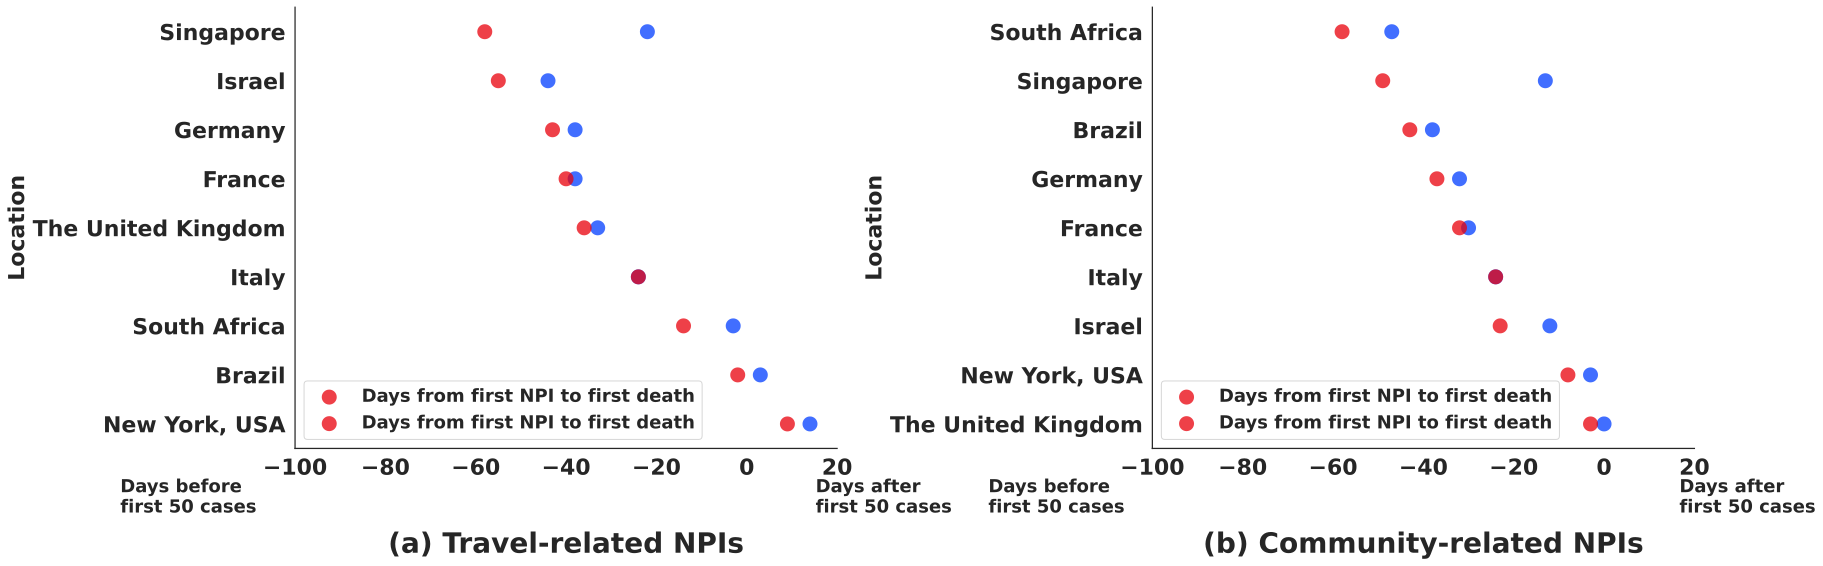

In [26]:
plot_fig_10(travel_related_NPIs[~travel_related_NPIs.index.isin(africa)].copy(), community_related_NPIs[~community_related_NPIs.index.isin(africa)].copy(), 'global')

### Figure 10b: Uganda, DRC, Senegal , Nigeria & Cameroun travel and community related NPIs analysis 

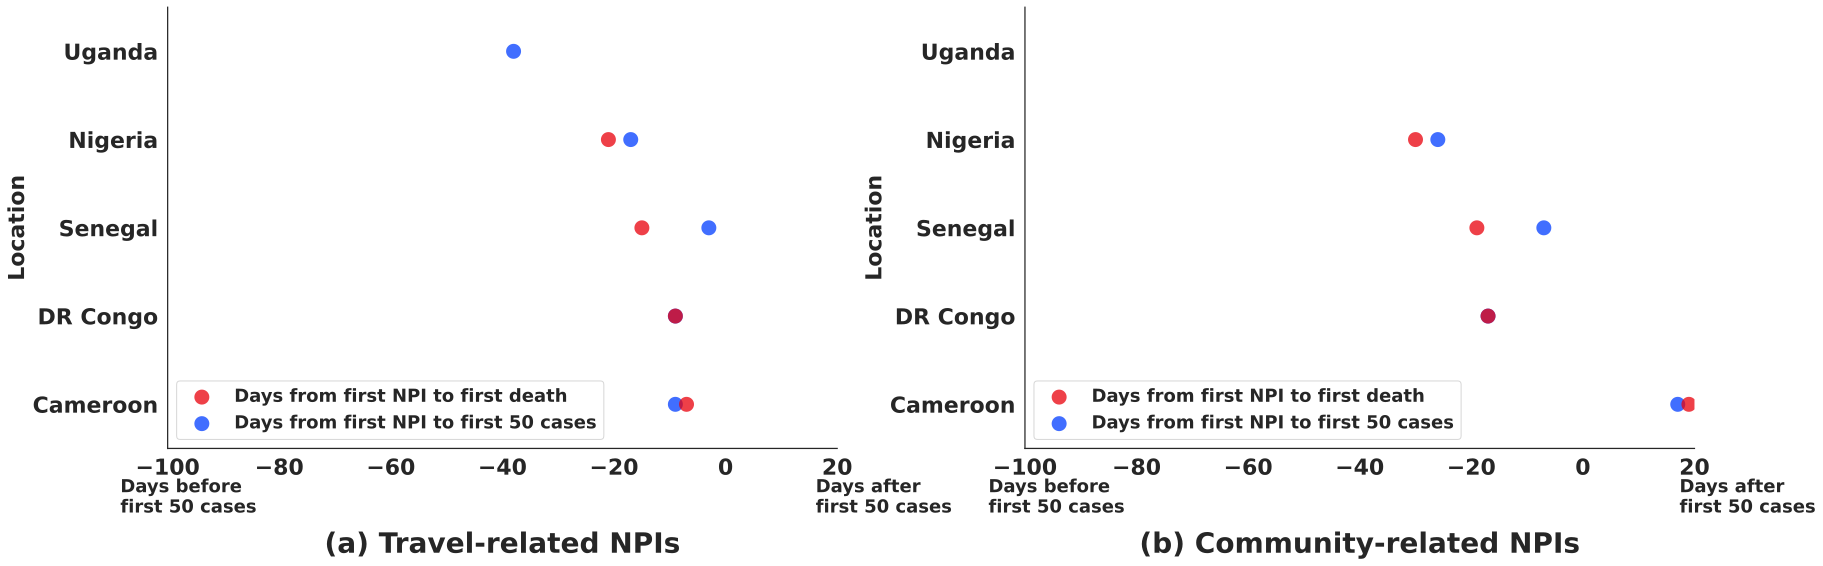

In [27]:
plot_fig_10(travel_related_NPIs[travel_related_NPIs.index.isin(africa)].copy(), community_related_NPIs[community_related_NPIs.index.isin(africa)].copy(), 'maksph')

<a id="fig12"></a>

[Top](#top)
## 8. Figure 12: Adherence to NPIs 

Figure illustrates the differences in indices using data from representative territories

In [28]:
#1. load NPI datasets
npi_df = wntrac_events_df.copy()
replacements = {'2019-03-18':'2020-03-18', '2019-05-06':'2020-05-06'}
npi_df = npi_df.replace({'date' : replacements})
npi_df['date'] = pd.to_datetime(npi_df['date'])
npi_df = npi_df.replace({'country' : {'KOS':'KVX'}})
npi_df[(~npi_df['state/province'].isna()) & (npi_df['country']!='USA')].tail(10)

,type,country,state/province,epoch,even_id,date,value,restriction
7640,public transportation,CHN,CHN-HK,1.611965e+12,d18e62b0-c43a-11eb-96f4-eeee0af69f08,2021-01-30,Total cancellation of transport (special case ...,1
7641,international flight restrictions,CHN,CHN-HK,1.611792e+12,f36c94a6-c43a-11eb-82da-eeee0af7b750,2021-01-28,other,1
7642,public transportation,CHN,CHN-HK,1.611792e+12,0093e558-c43b-11eb-8d83-eeee0af69f08,2021-01-28,Partial cancellation of routes/stops during th...,1
7643,public transportation,CHN,CHN-HK,1.611792e+12,11c14032-c43b-11eb-85c6-eeee0af4f824,2021-01-28,na,1
7644,freedom of movement (nationality dependent),CHN,CHN-HK,1.611792e+12,22818e54-c43b-11eb-97b7-eeee0af4f824,2021-01-28,other,1
7645,entertainment/cultural sector closure,CHN,CHN-HK,1.611878e+12,4cc733a8-c43b-11eb-9e51-eeee0af69f08,2021-01-29,"Museums, theaters, cinema, libraries, festivities",1
7653,freedom of movement (nationality dependent),CHN,CHN-HK,1.580342e+12,7b06938e-ce8c-11eb-af7c-eeee0af568d7,2020-01-30,CHN-HB,1
7654,entertainment/cultural sector closure,CHN,CHN-HK,1.583021e+12,99ea380a-ce8c-11eb-917f-eeee0af4daca,2020-03-01,"Museums, theaters, cinema, libraries, festivities",1
7656,entertainment/cultural sector closure,CHN,CHN-HK,1.585613e+12,3027f820-ce8d-11eb-b447-eeee0af48c63,2020-03-31,na,1
7664,entertainment/cultural sector closure,DEN,DEN-FI,1.622678e+12,aeb9f7a2-ce91-11eb-9c17-eeee0af48c63,2021-06-03,"Museums, theaters, cinema, libraries, festivities",1


In [29]:
#2. Selected a subset of 13 NPIs for subsequent analysis.
exclusion_list = ['economic impact','contact tracing','changes in prison-related policies', 'domestic of movement','other']
npi_df_filtered = npi_df[~npi_df['type'].isin(exclusion_list)]
npi_df_filtered

,type,country,state/province,epoch,even_id,date,value,restriction
0,introduction of travel quarantine policies,COM,NaN,1.585699e+12,02cf87e0-bcfe-11ea-b7bb-eeee0af7a662,2020-04-01,na,1
1,school closure,ZAF,NaN,1.584835e+12,07280ce6-c072-11ea-87f4-eeee0af469a3,2020-03-22,Only schools (primary/secondary) closed,1
2,entertainment/cultural sector closure,NGA,NaN,1.585008e+12,2ae3ffb2-c0e7-11ea-908e-eeee0af49f8d,2020-03-24,Churches,1
3,entertainment/cultural sector closure,COL,NaN,1.593907e+12,062dec18-c0ed-11ea-a39b-eeee0af72e81,2020-07-05,"Bars, restaurants, night clubs",1
4,entertainment/cultural sector closure,AUS,NaN,1.585094e+12,93824444-c2c1-11ea-bf59-eeee0af6f646,2020-03-25,Gyms and pools,1
...,...,...,...,...,...,...,...,...
7673,mask wearing,ISR,NaN,1.623715e+12,b09a993a-ce98-11eb-8452-eeee0af46888,2021-06-15,Mandatory,0
7674,entertainment/cultural sector closure,JPN,NaN,1.592006e+12,f424d4fe-ce98-11eb-a995-eeee0af5625a,2020-06-13,"Museums, theaters, cinema, libraries, festivities",1
7675,freedom of movement (nationality dependent),COL,NaN,1.593475e+12,afdbe5b0-d287-11eb-86af-eeee0af568d7,2020-06-30,all,0
7676,mask wearing,USA,USA-IA,1.621296e+12,27b24570-d288-11eb-9d04-eeee0af568d7,2021-05-18,Mandatory,0


In [30]:
#3. Get only US state data
npi_df_filtered = npi_df_filtered[(npi_df_filtered['state/province'].isna())|(npi_df_filtered['state/province']=='None')]
npi_df_filtered

,type,country,state/province,epoch,even_id,date,value,restriction
0,introduction of travel quarantine policies,COM,NaN,1.585699e+12,02cf87e0-bcfe-11ea-b7bb-eeee0af7a662,2020-04-01,na,1
1,school closure,ZAF,NaN,1.584835e+12,07280ce6-c072-11ea-87f4-eeee0af469a3,2020-03-22,Only schools (primary/secondary) closed,1
2,entertainment/cultural sector closure,NGA,NaN,1.585008e+12,2ae3ffb2-c0e7-11ea-908e-eeee0af49f8d,2020-03-24,Churches,1
3,entertainment/cultural sector closure,COL,NaN,1.593907e+12,062dec18-c0ed-11ea-a39b-eeee0af72e81,2020-07-05,"Bars, restaurants, night clubs",1
4,entertainment/cultural sector closure,AUS,NaN,1.585094e+12,93824444-c2c1-11ea-bf59-eeee0af6f646,2020-03-25,Gyms and pools,1
...,...,...,...,...,...,...,...,...
7670,entertainment/cultural sector closure,IDN,NaN,1.608768e+12,1360a0b8-ce95-11eb-ab04-eeee0af48c63,2020-12-24,"Museums, theaters, cinema, libraries, festivities",1
7671,work restrictions,IRN,NaN,1.616544e+12,58f0b000-ce95-11eb-b4fa-eeee0af48c63,2021-03-24,Suggestion to work from home for non-essential...,1
7673,mask wearing,ISR,NaN,1.623715e+12,b09a993a-ce98-11eb-8452-eeee0af46888,2021-06-15,Mandatory,0
7674,entertainment/cultural sector closure,JPN,NaN,1.592006e+12,f424d4fe-ce98-11eb-a995-eeee0af5625a,2020-06-13,"Museums, theaters, cinema, libraries, festivities",1


In [31]:
#4. Discard NPI events with future dates
date_string = '2021-12-01'
last_date = datetime.strptime(date_string, '%Y-%m-%d')
npi_df_filtered= npi_df_filtered[npi_df_filtered['date']<=last_date]
npi_df_filtered.tail(5)

,type,country,state/province,epoch,even_id,date,value,restriction
7670,entertainment/cultural sector closure,IDN,NaN,1.608768e+12,1360a0b8-ce95-11eb-ab04-eeee0af48c63,2020-12-24,"Museums, theaters, cinema, libraries, festivities",1
7671,work restrictions,IRN,NaN,1.616544e+12,58f0b000-ce95-11eb-b4fa-eeee0af48c63,2021-03-24,Suggestion to work from home for non-essential...,1
7673,mask wearing,ISR,NaN,1.623715e+12,b09a993a-ce98-11eb-8452-eeee0af46888,2021-06-15,Mandatory,0
7674,entertainment/cultural sector closure,JPN,NaN,1.592006e+12,f424d4fe-ce98-11eb-a995-eeee0af5625a,2020-06-13,"Museums, theaters, cinema, libraries, festivities",1
7675,freedom of movement (nationality dependent),COL,NaN,1.593475e+12,afdbe5b0-d287-11eb-86af-eeee0af568d7,2020-06-30,all,0


In [32]:
#5. select distinct US State-NPI-date tuples
npi_df_filtered = npi_df_filtered.drop(['epoch','even_id','value'],axis=1).drop_duplicates().sort_values(['state/province', 'type', 'date'])
mask = npi_df_filtered['restriction']!= npi_df_filtered.groupby(['type','state/province'])['restriction'].shift(1)
npi_df_filtered = npi_df_filtered[mask]
npi_df_filtered['end_date'] = npi_df_filtered.groupby(['type','state/province','type'])['date'].shift(-1)
npi_df_filtered['end_date'] =npi_df_filtered['end_date'].fillna(last_date)
npi_df_filtered[npi_df_filtered['country']=='NGA'].head(50)

,type,country,state/province,date,restriction,end_date
3696,confinement,NGA,NaN,2020-03-23,1,2021-12-01
4812,confinement,NGA,NaN,2020-03-29,1,2021-12-01
4810,confinement,NGA,NaN,2020-03-30,1,2021-12-01
4809,confinement,NGA,NaN,2020-04-01,1,2021-12-01
4818,confinement,NGA,NaN,2020-04-02,1,2021-12-01
4833,confinement,NGA,NaN,2020-04-11,1,2021-12-01
4831,confinement,NGA,NaN,2020-04-21,1,2021-12-01
4834,confinement,NGA,NaN,2020-04-27,1,2021-12-01
3247,confinement,NGA,NaN,2020-04-30,0,2021-12-01
7401,confinement,NGA,NaN,2020-05-02,1,2021-12-01


In [33]:
#MUSPH focus countries
npi_freq_musph_countries = npi_df_filtered[['type','country']][(npi_df_filtered['country'].isin(africa)) & (npi_df_filtered['restriction']==1)].drop_duplicates()
no_of_countries = len(list(set(npi_freq_musph_countries['country'])))
npi_freq_musph_countries = npi_freq_musph_countries.groupby('type')['country'].count().reset_index(name='freq')
npi_freq_musph_countries['prop'] = npi_freq_musph_countries['freq']/no_of_countries
npi_freq_musph_countries = npi_freq_musph_countries.sort_values('type', ascending = False)
npi_freq_musph_countries['region']= 'CD,NG,SE,UG'
npi_freq_musph_countries    


,type,freq,prop,region
12,work restrictions,4,0.8,"CD,NG,SE,UG"
11,state of emergency (legal impact),3,0.6,"CD,NG,SE,UG"
10,school closure,3,0.6,"CD,NG,SE,UG"
9,public transportation,3,0.6,"CD,NG,SE,UG"
8,public services closure,3,0.6,"CD,NG,SE,UG"
7,mass gatherings,4,0.8,"CD,NG,SE,UG"
6,mask wearing,5,1.0,"CD,NG,SE,UG"
5,introduction of travel quarantine policies,3,0.6,"CD,NG,SE,UG"
4,international flight restrictions,5,1.0,"CD,NG,SE,UG"
3,freedom of movement (nationality dependent),5,1.0,"CD,NG,SE,UG"


In [34]:
#World (excluding US and MUSPH focus countries)
npi_freq_worldwide = npi_df_filtered[['type','country']][(npi_df_filtered['restriction']==1)].drop_duplicates()
no_of_countries = len(list(set(npi_freq_worldwide['country'])))
print(no_of_countries)
npi_freq_worldwide = npi_freq_worldwide.groupby('type')['country'].count().reset_index(name='freq')
npi_freq_worldwide['prop'] = npi_freq_worldwide['freq']/no_of_countries
npi_freq_worldwide = npi_freq_worldwide.sort_values('type', ascending = False)
npi_freq_worldwide['region']= 'Worldwide'
npi_freq_worldwide

184


,type,freq,prop,region
12,work restrictions,80,0.434783,Worldwide
11,state of emergency (legal impact),76,0.413043,Worldwide
10,school closure,139,0.755435,Worldwide
9,public transportation,46,0.250000,Worldwide
8,public services closure,47,0.255435,Worldwide
7,mass gatherings,79,0.429348,Worldwide
6,mask wearing,121,0.657609,Worldwide
5,introduction of travel quarantine policies,90,0.489130,Worldwide
4,international flight restrictions,124,0.673913,Worldwide
3,freedom of movement (nationality dependent),143,0.777174,Worldwide


In [35]:
all_npi_freq = pd.concat([npi_freq_worldwide,npi_freq_musph_countries], axis = 0)
all_npi_freq = all_npi_freq.sort_values(['type','region'], ascending=True)
all_npi_freq

,type,freq,prop,region
0,confinement,5,1.000000,"CD,NG,SE,UG"
0,confinement,152,0.826087,Worldwide
1,domestic flight restriction,3,0.600000,"CD,NG,SE,UG"
1,domestic flight restriction,27,0.146739,Worldwide
2,entertainment/cultural sector closure,5,1.000000,"CD,NG,SE,UG"
2,entertainment/cultural sector closure,129,0.701087,Worldwide
3,freedom of movement (nationality dependent),5,1.000000,"CD,NG,SE,UG"
3,freedom of movement (nationality dependent),143,0.777174,Worldwide
4,international flight restrictions,5,1.000000,"CD,NG,SE,UG"
4,international flight restrictions,124,0.673913,Worldwide


In [36]:
all_npi_freq_merge = npi_freq_worldwide.merge(npi_freq_musph_countries, on = 'type')
all_npi_freq_merge['diff'] = all_npi_freq_merge.apply(lambda row: row.prop_y - row.prop_x, axis=1)
all_npi_freq_merge = all_npi_freq_merge.sort_values('diff')
all_npi_freq_merge

,type,freq_x,prop_x,region_x,freq_y,prop_y,region_y,diff
2,school closure,139,0.755435,Worldwide,3,0.6,"CD,NG,SE,UG",-0.155435
7,introduction of travel quarantine policies,90,0.489130,Worldwide,3,0.6,"CD,NG,SE,UG",0.110870
12,confinement,152,0.826087,Worldwide,5,1.0,"CD,NG,SE,UG",0.173913
1,state of emergency (legal impact),76,0.413043,Worldwide,3,0.6,"CD,NG,SE,UG",0.186957
9,freedom of movement (nationality dependent),143,0.777174,Worldwide,5,1.0,"CD,NG,SE,UG",0.222826
10,entertainment/cultural sector closure,129,0.701087,Worldwide,5,1.0,"CD,NG,SE,UG",0.298913
8,international flight restrictions,124,0.673913,Worldwide,5,1.0,"CD,NG,SE,UG",0.326087
6,mask wearing,121,0.657609,Worldwide,5,1.0,"CD,NG,SE,UG",0.342391
4,public services closure,47,0.255435,Worldwide,3,0.6,"CD,NG,SE,UG",0.344565
3,public transportation,46,0.250000,Worldwide,3,0.6,"CD,NG,SE,UG",0.350000


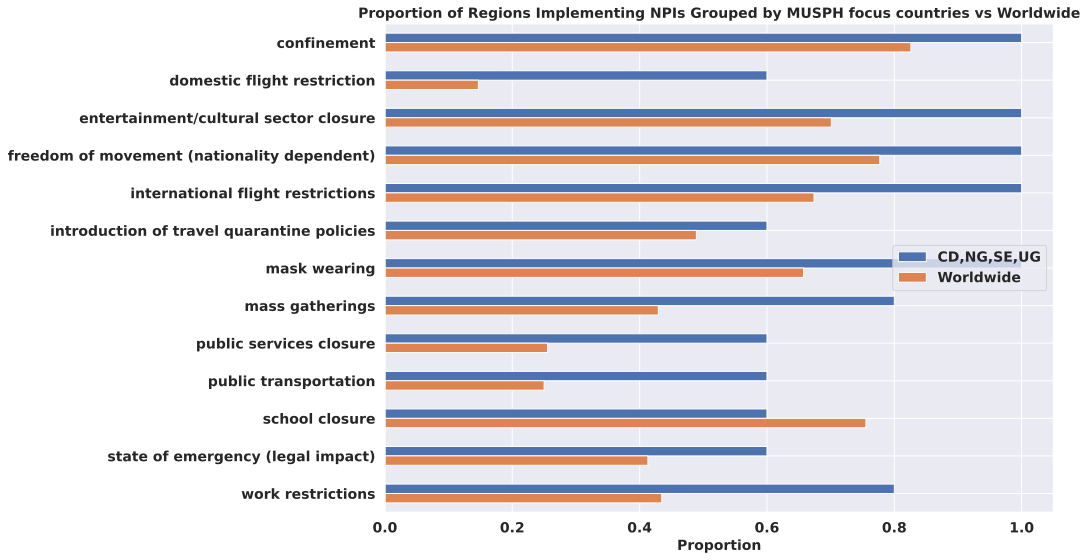

In [37]:
sns.set(rc={'figure.figsize':(12,9)})
all_npi_freq_pivot = all_npi_freq.pivot("type", "region", "prop").plot(kind='barh')
ax = all_npi_freq_pivot.plot(kind='barh')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.xlabel('Proportion',fontsize=14)
plt.ylabel('')
plt.legend(title='',loc=7, fontsize=14)
plt.title('Proportion of Regions Implementing NPIs Grouped by MUSPH focus countries vs Worldwide',fontsize=14,fontweight='bold')
plt.savefig('plots/Proportion of Regions Implementing NPIs Grouped by MUSPH focus countries vs Worldwide.png',bbox_inches='tight', pad_inches=0, dpi =300)

In [38]:
#get npi date ranges
npi_date_ranges = dict()
for country in list(set(npi_df_filtered['country'])):
    country_npi_date_ranges = dict()
    country_npi_list = list(set(npi_df_filtered['type'][npi_df_filtered['country']==country]))
    for npi in country_npi_list:
        country_npi_df =  npi_df_filtered[(npi_df_filtered['country']==country) & (npi_df_filtered['type']==npi)].copy()
        country_npi_df['date_range'] = country_npi_df.apply(lambda row: pd.date_range(start= row.date, end=row.end_date, closed='left'), axis=1)
        imposed_range = list(country_npi_df['date_range'][country_npi_df['restriction']==1])
        imposed_range_dict = {item: 1 for sublist in imposed_range for item in sublist}
        lifted_range = country_npi_df['date_range'][country_npi_df['restriction']==0]
        lifted_range_dict =  {item:0 for sublist in lifted_range for item in sublist}
        restriction = {**imposed_range_dict, **lifted_range_dict}
        country_npi_date_ranges[npi] =restriction
    npi_date_ranges[country] = country_npi_date_ranges
# npi_date_ranges['NGA']['confinement'] 

In [39]:
#countries
countries = sorted(list(np.unique(npi_df_filtered['country'])))

In [40]:
npi_list = sorted(list(np.unique(npi_df_filtered['type'])))
npi_list = [i for i in npi_list if i not in exclusion_list]
npi_list

['confinement',
 'domestic flight restriction',
 'entertainment/cultural sector closure',
 'freedom of movement (nationality dependent)',
 'international flight restrictions',
 'introduction of travel quarantine policies',
 'mask wearing',
 'mass gatherings',
 'public services closure',
 'public transportation',
 'school closure',
 'state of emergency (legal impact)',
 'work restrictions']

In [41]:
who_case_npi_df= who_case_df.copy()
def get_npi_status(country, npi, date,npi_date_ranges):
    if date in npi_date_ranges[country][npi].keys():
        return npi_date_ranges[country][npi][date]
    return 0
    
for npi in npi_list:
    #get list of countries with npi
    npi_countries = list(set(npi_df_filtered['country'][npi_df_filtered['type']==npi]))
    npi_colname = npi.replace(' ','_').replace('/','_or_').replace('(','_').replace(')','').replace('__','_')
    
    who_case_npi_df[npi_colname] = who_case_npi_df.apply(lambda row: get_npi_status(row.country_code, npi, row.date_reported,npi_date_ranges) if (row.country_code in npi_countries) else 0, axis=1)

who_case_npi_df[who_case_npi_df['country']!='US'].head(20)  

,date_reported,country_code,country,who_region,new_cases,cumulative_cases,new_deaths,cumulative_deaths,days_since_first_case,days_since_fifty_cases,...,freedom_of_movement_nationality_dependent,international_flight_restrictions,introduction_of_travel_quarantine_policies,mask_wearing,mass_gatherings,public_services_closure,public_transportation,school_closure,state_of_emergency_legal_impact,work_restrictions
0,2020-01-03,AFG,Afghanistan,EMRO,0,0,0,0,-52,-82.0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-04,AFG,Afghanistan,EMRO,0,0,0,0,-51,-81.0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-05,AFG,Afghanistan,EMRO,0,0,0,0,-50,-80.0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-06,AFG,Afghanistan,EMRO,0,0,0,0,-49,-79.0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-07,AFG,Afghanistan,EMRO,0,0,0,0,-48,-78.0,...,0,0,0,0,0,0,0,0,0,0
5,2020-01-08,AFG,Afghanistan,EMRO,0,0,0,0,-47,-77.0,...,0,0,0,0,0,0,0,0,0,0
6,2020-01-09,AFG,Afghanistan,EMRO,0,0,0,0,-46,-76.0,...,0,0,0,0,0,0,0,0,0,0
7,2020-01-10,AFG,Afghanistan,EMRO,0,0,0,0,-45,-75.0,...,0,0,0,0,0,0,0,0,0,0
8,2020-01-11,AFG,Afghanistan,EMRO,0,0,0,0,-44,-74.0,...,0,0,0,0,0,0,0,0,0,0
9,2020-01-12,AFG,Afghanistan,EMRO,0,0,0,0,-43,-73.0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
#Load data with indices
dat = wntrac_npi_index.copy()
dat['date'] =pd.to_datetime(dat['date'])
dat = dat.rename(columns={'admin0_name': 'country'})
dat = dat[(dat['country']!='United States') & (dat['admin1_name'].isna())].copy()
dat

KeyError: 'date'

In [43]:
stringency_index_wntrac = dict()
npi_index_wntrac = dict()
stringency_index_oxcgrt = dict()
npi_index_oxcgrt = dict()
compliance_wntrac = dict()
compliance_oxcgrt = dict()

for country in set(dat['country']):
    country_stringency_wntrac = dict()
    country_npi_index_wntrac = dict()
    country_stringency_index_oxcgrt = dict()
    country_npi_index_oxcgrt = dict()
    country_compliance_wntrac = dict()
    country_compliance_oxcgrt = dict()
    
    country_dat = dat[dat['country']==country]
    for date in set(country_dat['date']):
        country_stringency_wntrac[date] = country_dat['si_wntrac_transit_stations'][country_dat['date']==date].iloc[0]
        country_npi_index_wntrac[date] = country_dat['ni_wntrac_transit_stations'][country_dat['date']==date].iloc[0]
        country_stringency_index_oxcgrt[date] = country_dat['si_oxcgrt_transit_stations'][country_dat['date']==date].iloc[0]
        country_npi_index_oxcgrt[date] = country_dat['ni_oxcgrt_transit_stations'][country_dat['date']==date].iloc[0]
        country_compliance_wntrac[date] = country_dat['cs_wntrac_transit_stations'][country_dat['date']==date].iloc[0]
        country_compliance_oxcgrt[date] = country_dat['cs_oxcgrt_transit_stations'][country_dat['date']==date].iloc[0]
        
    stringency_index_wntrac[country] = country_stringency_wntrac
    npi_index_wntrac[country] = country_npi_index_wntrac
    stringency_index_oxcgrt[country] = country_stringency_index_oxcgrt
    npi_index_oxcgrt[country] = country_npi_index_oxcgrt
    compliance_wntrac[country] = country_compliance_wntrac
    compliance_oxcgrt[country] = country_compliance_oxcgrt
    
# npi_index_wntrac

KeyError: 'country'

In [ ]:
def get_stringency(country, date, stringency):
    if country in stringency.keys():
        if date in stringency[country].keys():
            return stringency[country][date]/100
        return None
    return None
who_case_npi_df['oxcgrt_si'] = who_case_npi_df.apply(lambda x: get_stringency(x.country, x.date_reported, stringency_index_oxcgrt), axis = 1)
who_case_npi_df['wntrac_si'] = who_case_npi_df.apply(lambda x: get_stringency(x.country, x.date_reported, stringency_index_wntrac), axis = 1)
who_case_npi_df[['date_reported','oxcgrt_si','wntrac_si']][who_case_npi_df['country'] == 'Uganda'].tail(10)

In [ ]:
def get_npi_index(country, date, npi_index):
    if country in npi_index.keys():
        if date in npi_index[country].keys():
            return npi_index[country][date]/100
        return None
    return None
who_case_npi_df['oxcgrt_npi_index'] = who_case_npi_df.apply(lambda x: get_npi_index(x.country, x.date_reported, npi_index_oxcgrt), axis = 1)
who_case_npi_df['wntrac_npi_index'] = who_case_npi_df.apply(lambda x: get_npi_index(x.country, x.date_reported, npi_index_wntrac), axis = 1)
who_case_npi_df[['date_reported','oxcgrt_si','wntrac_si','oxcgrt_npi_index','wntrac_npi_index']][who_case_npi_df['country'] == 'Uganda'].tail(10)

In [ ]:
def get_compliance(country, date, compliance):
    if country in compliance.keys():
        if date in compliance[country].keys():
            return compliance[country][date]
        return None
    return None
who_case_npi_df['oxcgrt_compliance'] = who_case_npi_df.apply(lambda x: get_compliance(x.country, x.date_reported, compliance_oxcgrt), axis = 1)
who_case_npi_df['wntrac_compliance'] = who_case_npi_df.apply(lambda x: get_compliance(x.country, x.date_reported, compliance_wntrac), axis = 1)
who_case_npi_df[['date_reported','oxcgrt_si','wntrac_si','oxcgrt_npi_index','wntrac_npi_index','oxcgrt_compliance','wntrac_compliance']][who_case_npi_df['country'] == 'Uganda'].tail(10)


In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("white")
mpl.rcParams['font.size'] = 16.0
mpl.rcParams["font.weight"] = "bold"
mpl.rcParams["axes.labelweight"] = "bold"

#Selected Geographics & Populations
selected_geographies ={
                        #'South Africa':58558267, 
                        'Uganda':45741007, 
                        'Nigeria': 207754443,
                        'Senegal': 16743927,
                        'Democratic Republic of the Congo':90414969,
                        'Cameroon':26545864,
                        #'Israel':8655535,
                        #'Belgium':11589623,
                        #'Kenya':53771296
                    }

npi_cols = ['confinement', 'domestic_flight_restriction','entertainment_or_cultural_sector_closure',
            'freedom_of_movement_nationality_dependent','international_flight_restrictions','introduction_of_travel_quarantine_policies', 
            'mask_wearing','mass_gatherings', 'public_services_closure', 
            'public_transportation','school_closure', 'state_of_emergency_legal_impact',
            'work_restrictions']

for geography in selected_geographies.keys():
    df = who_case_npi_df[who_case_npi_df['country']==geography].copy()
    df['npi_proportion'] = df[npi_cols].sum(axis = 1, skipna = True)/13
    df['new_cases_per_100k'] = (df['new_cases']*100000) / selected_geographies[geography]
    df['new_cases_per_100k_ewm7'] = df['new_cases_per_100k'].transform(lambda x: x.ewm(span=7).mean())
    #df['new_cases_per_100k_ewm7']= df['new_cases_per_100k_ewm7'].shift(-14)
    df = df[df['days_since_fifty_cases']>=0]
    df = df[~(df['new_cases_per_100k_ewm7'].isna())]
    print(df['date_reported'].max())
    day0 = df['date_reported'].iloc[0].date()
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    #lns1 = ax1.bar(df['date_reported'], df['new_cases_per_100k_ewm7'], color ="#0080ff",label='New cases per 100k')
    lns1 = ax1.plot(df['date_reported'], df['new_cases_per_100k_ewm7'], color ="#33adff",label='New cases per 100k')
    
    lns2 = ax2.plot(df["date_reported"], df['wntrac_si'], color="red", label='WNTRAC SI' )
    lns3 = ax2.plot(df["date_reported"], df['wntrac_compliance'], color="green", label='WNTRAC CS' )
    lns4 = ax2.plot(df['date_reported'], df['wntrac_npi_index'], linewidth=3,color="blue", label='WNTRAC NPI Index' )
    
    lns5 = ax2.plot(df['date_reported'], df['oxcgrt_si'], color="red", linestyle =':', label='OxCGRT Stringency Index' )
    lns6 = ax2.plot(df['date_reported'], df['oxcgrt_compliance'], color="green", linestyle =':', label='OxCGRT CS' )
    lns7 = ax2.plot(df['date_reported'], df['oxcgrt_npi_index'], color="blue", linestyle =':', label='OxCGRT-based NPI Index')
    
    ax1.set_xlabel("Date since 50 cases", fontsize=20, fontweight='bold')
    ax1.set_ylabel("New cases per 100k population", fontsize=20, fontweight='bold')
    #ax1.set_ylim([0,80])
    #ax1.legend(loc='upper left',fontsize=14)
    #ax2.set_ylabel("WNTRAC Proportion of NPIs\nWNTRAC NPI Index\nOxCGRT NPI Index\nOxCGRT Stringency Index", fontsize=14, fontweight='bold')
    ax2.set_ylabel("Index Value", fontsize=20, fontweight='bold')
    
    ax2.set_ylim([0,1.1])
    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax1.tick_params(axis='both', which='minor', labelsize=20)
    ax1.tick_params(axis='x', labelrotation=45)

    
    ax2.tick_params(axis='both', which='major', labelsize=20)
    ax2.tick_params(axis='both', which='minor', labelsize=20)
    ax1.tick_params(axis = "x", which = "both", bottom = True, top = False)
    
    date_form = mpl.dates.DateFormatter("%b %Y")
    ax1.xaxis.set_major_formatter(date_form)
#     ax1.set_xlim([datetime.strptime('2020-03-1', '%Y-%m-%d'),datetime.strptime(date_string, '%Y-%m-%d')])


#     ax1_labels= ['Mar\n2020', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan\n2021']

    
#     ax1.set_xticklabels(ax1_labels)
    
    lns = lns1 + lns2 + lns3 + lns4 + lns5 + lns6 + lns7
    labs = [l.get_label() for l in lns]
    
    d = np.zeros(df.shape[0])
    ax1.fill_between(x=df['date_reported'],y1=  df['new_cases_per_100k_ewm7'], interpolate=True, color="#33adff", alpha =.25)
 
    ax2.legend(lns, labs, fontsize=12, loc='upper right')
    plt.title(geography, fontsize=20, fontweight='bold')
    if not os.path.exists('plots'):
        os.makedirs('plots')
    fig.savefig("plots/npi_index_"+geography.replace(" ", "_").lower()+".jpeg", dpi=300,bbox_inches='tight')
    
    plt.show()
    plt.close()